In [ ]:
import numpy as np
from pathlib import Path
from typing import List, Dict
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch
from transformers import AutoModelForSequenceClassification
import accelerate
import transformers
from transformers import DistilBertConfig, DistilBertModel, DistilBertTokenizerFast
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer



In [63]:
from pathlib import Path
import pandas as pd
metadata_path = Path("../data/final_dataset_noaug2/metadata.csv")
df = pd.read_csv(metadata_path)
print(df.columns)
print(df.iloc[1])

Index(['image_path', 'label', 'caption'], dtype='object')
image_path                                     new_ball_196.jpg
label                                                Label.BALL
caption       In the sun-drenched backyard, a joyful black a...
Name: 1, dtype: object


### BASE MODEL CLASS

In [25]:
from enum import Enum
class Label(Enum):
    DOG = "dog"
    BIKE = "bike"
    BALL = "ball"
    WATER = "water"    


### UTILS METHODS


In [77]:
def get_label(filename: str):
    return filename.split("_")[0]


def get_uuid(filename: str):
    name = Path(filename).stem          
    parts = name.split("_")
    return "_".join(parts[:2])          


def build_augmented_path(img_path: Path, base_dir: Path):
    img_path = Path(img_path)
    filename = img_path.name
    label = get_label(filename)
    uuid = get_uuid(filename)
    pres = "_".join(filename.split(".")[0].split("_")[1:])
    return base_dir / uuid / pres / filename


def make_class_names(dataset):
    # dataset.class_to_idx: {label_str: idx}
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    return [idx_to_class[i] for i in range(len(idx_to_class))]


def count_oov_pct(sequences, oov_id):
    total = sum(1 for seq in sequences for tid in seq if tid != 0)
    oov = sum(1 for seq in sequences for tid in seq if tid == oov_id)
    return oov/total*100 if total > 0 else 0

class_to_idx = {
    "ball":  0,
    "bike":  1,
    "dog":   2,
    "water": 3,
}

class_names = ["ball", "bike", "dog", "water"]



### SMALLBERT MODEL

In [27]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.should_stop = False

    def step(self, metric):
        if self.best_score is None:
            self.best_score = metric
        elif metric < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_score = metric
            self.counter = 0


In [28]:
class PositionalEmbedding(nn.Module):
    def __init__(self, sequence_length: int, vocab_size:int, embed_dim:int):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_embeddings = nn.Embedding(sequence_length, embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        return self.token_embeddings(x) + self.position_embeddings(positions)


In [29]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout_rate: float = 0.1) -> None:
        super().__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor, padding_mask: torch.Tensor = None) -> torch.Tensor:
        attn_output, _ = self.att(
            x, x, x,
            key_padding_mask=padding_mask  # <-- correct masking
        )

        x = self.layernorm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(x)
        out = self.layernorm2(x + self.dropout2(ffn_output))
        return out


In [30]:
class SmallBERT(nn.Module):
    def __init__(self, sequence_length: int, vocab_size: int, embed_dim: int,
                 num_heads: int, ff_dim: int, num_layers: int) -> None:
        super().__init__()
        self.pos_embedding = PositionalEmbedding(sequence_length, vocab_size, embed_dim)
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim)
            for _ in range(num_layers)
        ])
        self.layernorm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, seq_len) token ids
        """
        padding_mask = (x == 0)  # 0 = PAD  -> True masked in attn
        x = self.pos_embedding(x)

        for block in self.blocks:
            x = block(x, padding_mask=padding_mask)

        x = self.layernorm(x)
        return self.dropout(x)


In [31]:
import torch
import torch.nn as nn

class SmallBERTPourClassification(nn.Module):
    def __init__(self, sequence_length: int, vocab_size: int, embed_dim: int,
                 num_heads: int, ff_dim: int, num_layers: int,
                 num_classes: int = 4) -> None:
        super().__init__()

        self.encoder = SmallBERT(sequence_length, vocab_size, embed_dim, num_heads, ff_dim, num_layers)

        # "Attention pooling" : score par token -> softmax -> somme pondérée
        self.pooler = nn.Linear(embed_dim, 1)

        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T) token ids, 0 = PAD
        """
        enc = self.encoder(x)  # (B, T, H)

        # masque PAD
        pad_mask = (x == 0)  # (B, T) True pour PAD

        # scores token-level
        scores = self.pooler(enc).squeeze(-1)  # (B, T)

        # on empêche le modèle d'attendre sur PAD : score = -inf pour PAD
        scores = scores.masked_fill(pad_mask, float("-inf"))

        # poids d'attention
        weights = torch.softmax(scores, dim=1)  # (B, T)

        # somme pondérée (pooled)
        pooled = torch.sum(enc * weights.unsqueeze(-1), dim=1)  # (B, H)

        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return logits


### DATASET LOADING METHODS

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

class SmallBertTextDataset(Dataset):
    def __init__(self, texts, labels, keras_tokenizer, max_vocab, seq_len):
        assert hasattr(keras_tokenizer, "texts_to_sequences"), \
            "SmallBertTextDataset attend un tokenizer Keras (Tokenizer), pas un tokenizer HuggingFace."
        assert hasattr(keras_tokenizer, "word_index"), \
            "Tokenizer Keras invalide."

        self.texts = list(texts)
        self.labels = np.asarray(labels, dtype=np.int64)
        self.tokenizer = keras_tokenizer
        self.max_vocab = int(max_vocab)
        self.seq_len = int(seq_len)

        oov_tok = getattr(self.tokenizer, "oov_token", "<OOV>")
        self.oov_id = self.tokenizer.word_index.get(oov_tok, 1)
        if self.oov_id is None or self.oov_id >= self.max_vocab:
            self.oov_id = 1

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        seq = self.tokenizer.texts_to_sequences([text])[0]
        seq = [
            t if (t is not None and 0 <= t < self.max_vocab) else self.oov_id
            for t in seq
        ]
        seq = pad_sequences(
            [seq],
            maxlen=self.seq_len,
            padding="post",
            truncating="post",
            value=0
        )[0].astype(np.int64)
        input_ids = torch.tensor(seq, dtype=torch.long)
        PAD_ID=0
        attention_mask = (input_ids != PAD_ID).long()

        return {
            "idx": torch.tensor(idx, dtype=torch.long),
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
            "text": text
        }

2026-01-19 00:48:31.029297: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-19 00:48:31.043193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768783711.060397   14251 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768783711.066228   14251 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-19 00:48:31.087149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

NameError: name 'Dataset' is not defined

In [ ]:
class HFTextDataset(Dataset):
    def __init__(self, texts, labels, hf_tokenizer, max_len):
        # Sécurité: refuse un tokenizer Keras
        assert hasattr(hf_tokenizer, "__call__"), \
            "HFTextDataset attend un tokenizer HuggingFace."
        assert not hasattr(hf_tokenizer, "texts_to_sequences"), \
            "HFTextDataset a reçu un tokenizer Keras par erreur."

        self.texts = list(texts)
        self.labels = np.asarray(labels, dtype=np.int64)
        self.tokenizer = hf_tokenizer
        self.max_len = int(max_len)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "idx": torch.tensor(idx, dtype=torch.long),
            "input_ids": enc["input_ids"].squeeze(0).to(torch.long),
            "attention_mask": enc["attention_mask"].squeeze(0).to(torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
            "text": text,
        }

### PREPROCESSING

In [ ]:
df_clean = df.drop_duplicates(subset="caption").reset_index(drop=True)


In [249]:
import nltk
import re
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def normalize_text(t):
    t = t.lower()
    t = re.sub(r"\d+", " ", t)                 # supprime les nombres
    t = re.sub(r"[^\w\s]", " ", t)             # ponctuation
    t = re.sub(r"\s+", " ", t).strip()
    return t
    words = [lemmatizer.lemmatize(w) for w in t.split()]
    return " ".join(words)


df_clean["caption"] = df_clean["caption"].apply(normalize_text)
df_clean["caption"].iloc[1]

lengths = df_clean["caption"].apply(lambda x: len(x.split()))

print(lengths.describe())

def normalize_label(lbl):
    s = str(lbl)
    if s.startswith("Label."):
        s = s.split(".", 1)[1]
    return s.lower()

df_clean["label"] = df_clean["label"].apply(normalize_label)


count    1400.000000
mean       46.509286
std        31.506740
min         3.000000
25%        12.000000
50%        62.000000
75%        74.000000
max       107.000000
Name: caption, dtype: float64


[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [250]:
p95 = int(lengths.quantile(0.95))
p98 = int(lengths.quantile(0.98))
max_len = int(lengths.max())

print(f"p95={p95}, p98={p98}, max={max_len}")


p95=86, p98=92, max=107


In [69]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=11, stratify=df["label"])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=11, stratify=df_temp["label"])


print(df_train["label"].value_counts(normalize=True) * 100)
print(df_val["label"].value_counts(normalize=True) * 100)
print(df_test["label"].value_counts(normalize=True) * 100)

X_train, y_train, caption_train = df_train["image_path"], df_train["label"], df_train["caption"]
X_val, y_val, caption_val  = df_val["image_path"], df_val["label"], df_val["caption"]
X_test, y_test, caption_test   = df_test["image_path"], df_test["label"], df_test["caption"]

X_train = caption_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = caption_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = caption_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("Avant :", len(df))
print("Après  :", len(df))
print("Doublons supprimés :", len(df) - len(df))



label
Label.DOG      25.0
Label.BALL     25.0
Label.BIKE     25.0
Label.WATER    25.0
Name: proportion, dtype: float64
label
Label.WATER    25.238095
Label.DOG      25.238095
Label.BIKE     24.761905
Label.BALL     24.761905
Name: proportion, dtype: float64
label
Label.BIKE     25.238095
Label.BALL     25.238095
Label.DOG      24.761905
Label.WATER    24.761905
Name: proportion, dtype: float64
Avant : 1400
Après  : 1400
Doublons supprimés : 0


In [252]:
def pad_oov_stats(loader):
    b = next(iter(loader))
    ids = b["input_ids"]
    return (ids==0).float().mean().item(), (ids==1).float().mean().item()

print("train PAD%, OOV%:", pad_oov_stats(train_loader))
print("test  PAD%, OOV%:", pad_oov_stats(test_loader))


train PAD%, OOV%: (0.4290178716182709, 0.05044642835855484)
test  PAD%, OOV%: (0.4937500059604645, 0.0491071417927742)


In [253]:
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_clean["caption"])
actual_vocab_size = len(tokenizer.word_index) + 1
print(f"   taille de vocabulaire: {len(tokenizer.word_index)}")
print(f"   vocab_size: {actual_vocab_size}")

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

oov_id = tokenizer.word_index["<OOV>"]

count = 0
for i in range(len(X_val_seq)):
    count += X_val_seq[i].count(oov_id)

print(count)

   taille de vocabulaire: 4212
   vocab_size: 4213
0


In [254]:
word_counts = tokenizer.word_counts
total = sum(word_counts.values())

def coverage(k):
    topk = sorted(word_counts.values(), reverse=True)[:k]
    return sum(topk) / total

for k in [1000, 2000, 3000, 4000]:
    print(k, f"{coverage(k)*100:.1f}%")

1000 89.4%
2000 95.7%
3000 98.1%
4000 99.7%


### TRAIN METHOD

In [255]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Test Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Test Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_multiclass_roc(y_true, y_prob, num_classes, class_names=None, title="ROC (One-vs-Rest)"):
    """
    y_true: [N] int labels
    y_prob: [N, C] probabilities
    """
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))  # [N, C]

    plt.figure(figsize=(8, 6))
    for c in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, c], y_prob[:, c])
        roc_auc = auc(fpr, tpr)
        name = class_names[c] if class_names is not None else f"Class {c}"
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

    # Diagonal
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [267]:
from tqdm import tqdm

def to_device_batch(batch, device):
    out = {}
    for k, v in batch.items():
        if torch.is_tensor(v):
            out[k] = v.to(device, non_blocking=True)
        else:
            out[k] = v
    return out

def forward_text(model, batch, arch="hf"):
    if arch == "hf":
        out = model(
            input_ids=batch["input_ids"],
            attention_mask=batch.get("attention_mask", None)
        )
        return out.logits
    elif arch == "smallbert":
        return model(batch["input_ids"])
    else:
        raise ValueError(f"arch inconnu: {arch}")



def train_one_epoch_text(model, loader, optimizer, criterion, device, epoch, epochs, arch="hf"):
    model.train()
    running_loss = 0.0

    loop = tqdm(loader, total=len(loader), desc=f"Epoch {epoch+1}/{epochs} [TRAIN]")
    for i, batch in enumerate(loop):
        batch = to_device_batch(batch, device)
        optimizer.zero_grad(set_to_none=True)

        logits = forward_text(model, batch, arch=arch)
        loss = criterion(logits, batch["labels"])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=running_loss / (i + 1))

    return running_loss / len(loader)

In [268]:
@torch.no_grad()
def evaluate_text(model, loader, criterion, device, epoch, epochs, num_classes, arch="hf",
                  class_names=None, n_mistakes_to_print=5):
    model.eval()
    running_loss = 0.0

    all_labels, all_preds, all_probs = [], [], []
    mistakes_printed = 0

    loop = tqdm(loader, total=len(loader), desc=f"Epoch {epoch+1}/{epochs} [EVAL]")
    for batch in loop:
        batch = to_device_batch(batch, device)

        logits = forward_text(model, batch, arch=arch)
        loss = criterion(logits, batch["labels"])
        running_loss += loss.item()

        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        all_labels.append(batch["labels"].detach().cpu())
        all_preds.append(preds.detach().cpu())
        all_probs.append(probs.detach().cpu())

        # debug erreurs (optionnel)
        if ("text" in batch) and mistakes_printed < n_mistakes_to_print:
            mism = (preds != batch["labels"]).detach().cpu()
            if mism.any():
                pos_list = torch.where(mism)[0].tolist()
                for pos in pos_list:
                    if mistakes_printed >= n_mistakes_to_print:
                        break
                    true_i = int(batch["labels"][pos].item())
                    pred_i = int(preds[pos].item())
                    t = batch["text"][pos]  # str
                    tn = class_names[true_i] if class_names else str(true_i)
                    pn = class_names[pred_i] if class_names else str(pred_i)
                    print("\n--- Mauvaise prédiction (texte) ---")
                    print(f"true: {tn} ({true_i}) | pred: {pn} ({pred_i})")
                    print(f"text: {t[:300]}{'...' if len(t) > 300 else ''}")
                    mistakes_printed += 1

    avg_loss = running_loss / len(loader)
    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_prob = torch.cat(all_probs).numpy()
    acc = float((torch.tensor(y_pred) == torch.tensor(y_true)).float().mean().item())

    return avg_loss, y_true, y_pred, y_prob, acc

In [ ]:
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report

@torch.no_grad()
def infer_text_loader(
    model,
    loader,
    device=None,
    arch="smallbert",              
    class_names=None,
    num_classes=None,              #si None y_prob.shape[1]
    show_report=True,
    plot_cm=True,
    plot_roc=True,
    n_mistakes_to_print=0
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()

    all_labels, all_preds, all_probs = [], [], []
    mistakes_printed = 0

    loop = tqdm(loader, total=len(loader), desc="Inference")
    for batch in loop:
        batch = to_device_batch(batch, device)

        logits = forward_text(model, batch, arch=arch)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        all_labels.append(batch["labels"].detach().cpu())
        all_preds.append(preds.detach().cpu())
        all_probs.append(probs.detach().cpu())

        # debug erreurs (optionnel)
        if ("text" in batch) and n_mistakes_to_print and mistakes_printed < n_mistakes_to_print:
            mism = (preds != batch["labels"]).detach().cpu()
            if mism.any():
                pos_list = torch.where(mism)[0].tolist()
                for pos in pos_list:
                    if mistakes_printed >= n_mistakes_to_print:
                        break
                    true_i = int(batch["labels"][pos].item())
                    pred_i = int(preds[pos].item())
                    t = batch["text"][pos]
                    tn = class_names[true_i] if class_names else str(true_i)
                    pn = class_names[pred_i] if class_names else str(pred_i)
                    print("\n--- Mauvaise prédiction (inference) ---")
                    print(f"true: {tn} ({true_i}) | pred: {pn} ({pred_i})")
                    print(f"text: {t[:300]}{'...' if len(t) > 300 else ''}")
                    mistakes_printed += 1

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_prob = torch.cat(all_probs).numpy()

    if num_classes is None:
        num_classes = y_prob.shape[1]

    acc = float((torch.tensor(y_pred) == torch.tensor(y_true)).float().mean().item())
    print(f"Accuracy: {acc:.4f}")

    if show_report:
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=3, target_names=class_names))

    if plot_cm:
        plot_confusion_matrix(
            y_true, y_pred,
            class_names=class_names,
            title="Confusion Matrix (Inference)"
        )

    if plot_roc:
        plot_multiclass_roc(
            y_true, y_prob,
            num_classes=num_classes,
            class_names=class_names,
            title="ROC (Inference, OvR)"
        )

    return {
        "acc": acc,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob
    }


In [270]:
from pathlib import Path
import torch.optim as optim
from sklearn.metrics import classification_report

def ensure_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)

def fit_text(
    model,
    train_loader,
    test_loader,
    num_classes=4,
    epochs=10,
    lr=2e-5,
    patience=2,
    models_dir=Path("../models"),
    best_name="best_text_model.pth",
    criterion=None,
    class_names=None,
    arch="hf",                 # "hf" (DistilBERT) ou "smallbert"
    optimizer_name="adamw"     # "adamw" ou "sgd"
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    if optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=lr)

    ensure_dir(models_dir)
    best_model_path = models_dir / best_name

    best_test_loss = float("inf")
    patience_counter = 0

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        train_loss = train_one_epoch_text(
            model, train_loader, optimizer, criterion, device, epoch, epochs, arch=arch
        )
        train_losses.append(train_loss)
        print(f"\nEpoch {epoch+1} - Average TRAIN loss: {train_loss:.4f}")

        test_loss, y_true, y_pred, y_prob, acc = evaluate_text(
            model, test_loader, criterion, device, epoch, epochs, num_classes=4,
            arch=arch, class_names=class_names, n_mistakes_to_print=0
        )
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1} - Average TEST loss: {test_loss:.4f} | acc={acc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=3, target_names=class_names))
        
        # Early stopping + save best
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            torch.save({
                "model_state": model.state_dict(),
                "class_names": class_names
            }, best_model_path)
            print(f"Nouveau meilleur modèle sauvegardé (test loss: {best_test_loss:.4f})")
        else:
            patience_counter += 1
            print(f"Pas d'amélioration ({patience_counter}/{patience})")
            if patience_counter >= patience:
                print(f"\nEarly stopping déclenché après {epoch+1} époques")
                print(f"Meilleur test loss: {best_test_loss:.4f}")
                break

    # Load best model + final eval for plots
    print(f"\nChargement du meilleur modèle (test loss: {best_test_loss:.4f})")
    torch.save({
                    "model_state": model.state_dict(),
                    "class_names": class_names
            }, best_model_path)
    final_test_loss, y_true, y_pred, y_prob, acc = evaluate_text(
        model, test_loader, criterion, device, epoch=0, epochs=1,  num_classes=4,
        arch=arch, class_names=class_names, n_mistakes_to_print=5,
    )
    print(f"Best model - TEST loss: {final_test_loss:.4f} | acc={acc:.4f}")

    # Plots (tu peux réutiliser tes fonctions inchangées)
    plot_losses(train_losses, test_losses)
    plot_confusion_matrix(y_true, y_pred, class_names=class_names, title="Confusion Matrix (Best Model)")
    plot_multiclass_roc(y_true, y_prob, num_classes=num_classes, class_names=class_names, title="ROC (Best Model, OvR)")

    return model, {"train_losses": train_losses, "test_losses": test_losses, "best_test_loss": best_test_loss}


### TRAIN 

In [271]:
MAX_VOCAB =  1000
OOV_TOKEN = "<OOV>"
SEQ_LEN = 70


tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(df_clean["caption"].tolist())

class_order = [Label.BALL, Label.BIKE, Label.DOG, Label.WATER]

y_train_idx = y_train.apply(lambda x: class_to_idx[x]).astype("int64")
y_val_idx   = y_val.apply(lambda x: class_to_idx[x]).astype("int64")
y_test_idx  = y_test.apply(lambda x: class_to_idx[x]).astype("int64")


train_ds = SmallBertTextDataset(X_train, y_train_idx, tokenizer, MAX_VOCAB, SEQ_LEN)
test_ds  = SmallBertTextDataset(X_test,  y_test_idx,  tokenizer, MAX_VOCAB, SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32)

model = SmallBERTPourClassification(
    vocab_size=MAX_VOCAB,
    sequence_length=SEQ_LEN,
    embed_dim=128,
    num_heads=4,
    ff_dim=256,
    num_layers=2,
    num_classes=4
)

In [272]:
seqs = tokenizer.texts_to_sequences(X_train[:5])
print(seqs)
print("Vocab size:", len(tokenizer.word_index))


[[3, 37, 12, 201, 4, 2, 20, 8, 3, 37, 1], [3, 127, 5, 385, 228, 122, 176, 8, 2, 53, 40, 41, 14, 168, 6, 434, 330, 2, 20, 7, 22, 137, 68, 2, 76, 35, 19, 77, 5, 118, 890, 16, 10, 247, 15, 713, 261, 16, 460, 112, 165, 34, 169, 17, 1, 584, 9, 2, 100, 4, 548, 583, 3, 471, 1, 8, 3, 52, 506, 271, 2, 408, 993, 10, 3, 599, 5, 923, 8, 15, 171], [3, 49, 24, 37, 6, 35, 12, 17, 1, 336, 3, 841, 40, 387, 4, 3, 53, 579, 136, 10, 67, 284, 6, 573, 56, 11, 71, 88, 310, 7, 16, 953, 11, 280, 2, 27, 50, 65, 192, 144, 8, 2, 41, 145, 11, 74, 129, 95, 262, 23, 5, 111, 229, 4, 2, 84, 2, 351, 89, 5, 141, 13, 168, 200, 18, 2, 20, 82, 9, 2, 276, 5, 241, 312, 46, 265, 79, 391, 23], [3, 321, 962, 1, 15, 123, 24, 36, 61, 3, 853, 405, 3, 816, 132, 9, 116, 15, 590, 68, 1, 3, 580, 51, 2, 227, 484, 2, 36, 13, 1, 1, 1, 4, 2, 50, 7, 2, 91, 1, 15, 738, 6, 316, 47, 2, 224, 392, 4, 2, 64, 2, 796, 5, 263, 1, 6, 960, 963, 265, 2, 20, 82, 9, 2, 97, 5, 2, 223, 167, 529], [3, 161, 24, 6, 576, 12, 11, 45, 115, 25, 4, 97, 207, 267, 

Epoch 1/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 93.35it/s, loss=1.41]



Epoch 1 - Average TRAIN loss: 1.4086


Epoch 1/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 224.20it/s]


Epoch 1 - Average TEST loss: 1.3555 | acc=0.3619

Classification Report:
              precision    recall  f1-score   support

         dog      0.545     0.226     0.320        53
        bike      0.455     0.189     0.267        53
        ball      0.304     0.731     0.429        52
       water      0.390     0.308     0.344        52

    accuracy                          0.362       210
   macro avg      0.424     0.363     0.340       210
weighted avg      0.424     0.362     0.340       210

Nouveau meilleur modèle sauvegardé (test loss: 1.3555)


Epoch 2/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 94.63it/s, loss=1.36]



Epoch 2 - Average TRAIN loss: 1.3572


Epoch 2/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 226.16it/s]


Epoch 2 - Average TEST loss: 1.3157 | acc=0.4381

Classification Report:
              precision    recall  f1-score   support

         dog      0.560     0.264     0.359        53
        bike      0.556     0.283     0.375        53
        ball      0.418     0.731     0.531        52
       water      0.373     0.481     0.420        52

    accuracy                          0.438       210
   macro avg      0.477     0.440     0.421       210
weighted avg      0.477     0.438     0.421       210

Nouveau meilleur modèle sauvegardé (test loss: 1.3157)


Epoch 3/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 94.48it/s, loss=1.31]



Epoch 3 - Average TRAIN loss: 1.3130


Epoch 3/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 219.07it/s]


Epoch 3 - Average TEST loss: 1.2694 | acc=0.4762

Classification Report:
              precision    recall  f1-score   support

         dog      0.650     0.245     0.356        53
        bike      0.583     0.396     0.472        53
        ball      0.417     0.865     0.562        52
       water      0.457     0.404     0.429        52

    accuracy                          0.476       210
   macro avg      0.527     0.478     0.455       210
weighted avg      0.527     0.476     0.454       210

Nouveau meilleur modèle sauvegardé (test loss: 1.2694)


Epoch 4/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 96.39it/s, loss=1.24]



Epoch 4 - Average TRAIN loss: 1.2443


Epoch 4/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 222.43it/s]


Epoch 4 - Average TEST loss: 1.2115 | acc=0.5238

Classification Report:
              precision    recall  f1-score   support

         dog      0.409     0.509     0.454        53
        bike      0.639     0.434     0.517        53
        ball      0.579     0.846     0.688        52
       water      0.500     0.308     0.381        52

    accuracy                          0.524       210
   macro avg      0.532     0.524     0.510       210
weighted avg      0.532     0.524     0.510       210

Nouveau meilleur modèle sauvegardé (test loss: 1.2115)


Epoch 5/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 95.08it/s, loss=1.17]



Epoch 5 - Average TRAIN loss: 1.1731


Epoch 5/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 230.20it/s]


Epoch 5 - Average TEST loss: 1.1482 | acc=0.5476

Classification Report:
              precision    recall  f1-score   support

         dog      0.786     0.208     0.328        53
        bike      0.710     0.415     0.524        53
        ball      0.638     0.846     0.727        52
       water      0.396     0.731     0.514        52

    accuracy                          0.548       210
   macro avg      0.632     0.550     0.523       210
weighted avg      0.633     0.548     0.522       210

Nouveau meilleur modèle sauvegardé (test loss: 1.1482)


Epoch 6/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 96.08it/s, loss=1.1] 



Epoch 6 - Average TRAIN loss: 1.1016


Epoch 6/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 226.05it/s]


Epoch 6 - Average TEST loss: 1.0853 | acc=0.6143

Classification Report:
              precision    recall  f1-score   support

         dog      0.545     0.453     0.495        53
        bike      0.706     0.679     0.692        53
        ball      0.618     0.808     0.700        52
       water      0.574     0.519     0.545        52

    accuracy                          0.614       210
   macro avg      0.611     0.615     0.608       210
weighted avg      0.611     0.614     0.608       210

Nouveau meilleur modèle sauvegardé (test loss: 1.0853)


Epoch 7/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 97.79it/s, loss=1.03]



Epoch 7 - Average TRAIN loss: 1.0283


Epoch 7/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 224.18it/s]


Epoch 7 - Average TEST loss: 1.0342 | acc=0.6238

Classification Report:
              precision    recall  f1-score   support

         dog      0.824     0.264     0.400        53
        bike      0.704     0.717     0.710        53
        ball      0.618     0.904     0.734        52
       water      0.508     0.615     0.557        52

    accuracy                          0.624       210
   macro avg      0.663     0.625     0.600       210
weighted avg      0.664     0.624     0.600       210

Nouveau meilleur modèle sauvegardé (test loss: 1.0342)


Epoch 8/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 96.18it/s, loss=0.949]



Epoch 8 - Average TRAIN loss: 0.9495


Epoch 8/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 229.89it/s]


Epoch 8 - Average TEST loss: 0.9631 | acc=0.6762

Classification Report:
              precision    recall  f1-score   support

         dog      0.857     0.453     0.593        53
        bike      0.683     0.811     0.741        53
        ball      0.648     0.885     0.748        52
       water      0.604     0.558     0.580        52

    accuracy                          0.676       210
   macro avg      0.698     0.677     0.665       210
weighted avg      0.699     0.676     0.665       210

Nouveau meilleur modèle sauvegardé (test loss: 0.9631)


Epoch 9/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 97.45it/s, loss=0.846]



Epoch 9 - Average TRAIN loss: 0.8459


Epoch 9/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 227.41it/s]


Epoch 9 - Average TEST loss: 0.8746 | acc=0.7000

Classification Report:
              precision    recall  f1-score   support

         dog      0.756     0.585     0.660        53
        bike      0.737     0.792     0.764        53
        ball      0.672     0.865     0.756        52
       water      0.644     0.558     0.598        52

    accuracy                          0.700       210
   macro avg      0.702     0.700     0.694       210
weighted avg      0.703     0.700     0.695       210

Nouveau meilleur modèle sauvegardé (test loss: 0.8746)


Epoch 10/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 96.34it/s, loss=0.733]



Epoch 10 - Average TRAIN loss: 0.7325


Epoch 10/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 220.52it/s]


Epoch 10 - Average TEST loss: 0.7751 | acc=0.7381

Classification Report:
              precision    recall  f1-score   support

         dog      0.833     0.660     0.737        53
        bike      0.804     0.774     0.788        53
        ball      0.717     0.827     0.768        52
       water      0.632     0.692     0.661        52

    accuracy                          0.738       210
   macro avg      0.746     0.738     0.738       210
weighted avg      0.747     0.738     0.739       210

Nouveau meilleur modèle sauvegardé (test loss: 0.7751)


Epoch 11/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 96.22it/s, loss=0.625]



Epoch 11 - Average TRAIN loss: 0.6249


Epoch 11/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 225.86it/s]


Epoch 11 - Average TEST loss: 0.7143 | acc=0.7619

Classification Report:
              precision    recall  f1-score   support

         dog      0.816     0.755     0.784        53
        bike      0.796     0.811     0.804        53
        ball      0.788     0.788     0.788        52
       water      0.655     0.692     0.673        52

    accuracy                          0.762       210
   macro avg      0.764     0.762     0.762       210
weighted avg      0.764     0.762     0.763       210

Nouveau meilleur modèle sauvegardé (test loss: 0.7143)


Epoch 12/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 98.36it/s, loss=0.553]



Epoch 12 - Average TRAIN loss: 0.5526


Epoch 12/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 230.89it/s]


Epoch 12 - Average TEST loss: 0.6691 | acc=0.7762

Classification Report:
              precision    recall  f1-score   support

         dog      0.784     0.755     0.769        53
        bike      0.821     0.868     0.844        53
        ball      0.804     0.788     0.796        52
       water      0.692     0.692     0.692        52

    accuracy                          0.776       210
   macro avg      0.775     0.776     0.775       210
weighted avg      0.776     0.776     0.776       210

Nouveau meilleur modèle sauvegardé (test loss: 0.6691)


Epoch 13/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 97.13it/s, loss=0.475]



Epoch 13 - Average TRAIN loss: 0.4754


Epoch 13/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 227.96it/s]


Epoch 13 - Average TEST loss: 0.6374 | acc=0.7762

Classification Report:
              precision    recall  f1-score   support

         dog      0.830     0.736     0.780        53
        bike      0.758     0.887     0.817        53
        ball      0.804     0.788     0.796        52
       water      0.720     0.692     0.706        52

    accuracy                          0.776       210
   macro avg      0.778     0.776     0.775       210
weighted avg      0.778     0.776     0.775       210

Nouveau meilleur modèle sauvegardé (test loss: 0.6374)


Epoch 14/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 96.72it/s, loss=0.432]



Epoch 14 - Average TRAIN loss: 0.4317


Epoch 14/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 220.96it/s]


Epoch 14 - Average TEST loss: 0.6109 | acc=0.7905

Classification Report:
              precision    recall  f1-score   support

         dog      0.826     0.717     0.768        53
        bike      0.828     0.906     0.865        53
        ball      0.792     0.808     0.800        52
       water      0.717     0.731     0.724        52

    accuracy                          0.790       210
   macro avg      0.791     0.790     0.789       210
weighted avg      0.791     0.790     0.789       210

Nouveau meilleur modèle sauvegardé (test loss: 0.6109)


Epoch 15/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 97.28it/s, loss=0.372]



Epoch 15 - Average TRAIN loss: 0.3717


Epoch 15/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 224.46it/s]


Epoch 15 - Average TEST loss: 0.6031 | acc=0.7952

Classification Report:
              precision    recall  f1-score   support

         dog      0.812     0.736     0.772        53
        bike      0.839     0.887     0.862        53
        ball      0.782     0.827     0.804        52
       water      0.745     0.731     0.738        52

    accuracy                          0.795       210
   macro avg      0.795     0.795     0.794       210
weighted avg      0.795     0.795     0.794       210

Nouveau meilleur modèle sauvegardé (test loss: 0.6031)


Epoch 16/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 95.37it/s, loss=0.346]



Epoch 16 - Average TRAIN loss: 0.3456


Epoch 16/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 229.30it/s]


Epoch 16 - Average TEST loss: 0.5879 | acc=0.8000

Classification Report:
              precision    recall  f1-score   support

         dog      0.812     0.736     0.772        53
        bike      0.842     0.906     0.873        53
        ball      0.804     0.788     0.796        52
       water      0.741     0.769     0.755        52

    accuracy                          0.800       210
   macro avg      0.800     0.800     0.799       210
weighted avg      0.800     0.800     0.799       210

Nouveau meilleur modèle sauvegardé (test loss: 0.5879)


Epoch 17/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 95.63it/s, loss=0.302]



Epoch 17 - Average TRAIN loss: 0.3018


Epoch 17/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 225.12it/s]


Epoch 17 - Average TEST loss: 0.5872 | acc=0.8095

Classification Report:
              precision    recall  f1-score   support

         dog      0.830     0.736     0.780        53
        bike      0.857     0.906     0.881        53
        ball      0.816     0.769     0.792        52
       water      0.741     0.827     0.782        52

    accuracy                          0.810       210
   macro avg      0.811     0.809     0.809       210
weighted avg      0.811     0.810     0.809       210

Nouveau meilleur modèle sauvegardé (test loss: 0.5872)


Epoch 18/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 96.45it/s, loss=0.267]



Epoch 18 - Average TRAIN loss: 0.2668


Epoch 18/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 229.19it/s]


Epoch 18 - Average TEST loss: 0.6149 | acc=0.8000

Classification Report:
              precision    recall  f1-score   support

         dog      0.816     0.755     0.784        53
        bike      0.803     0.925     0.860        53
        ball      0.833     0.769     0.800        52
       water      0.750     0.750     0.750        52

    accuracy                          0.800       210
   macro avg      0.801     0.800     0.798       210
weighted avg      0.801     0.800     0.799       210

Pas d'amélioration (1/2)


Epoch 19/20 [TRAIN]: 100%|██████████| 31/31 [00:00<00:00, 95.00it/s, loss=0.255]



Epoch 19 - Average TRAIN loss: 0.2546


Epoch 19/20 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 231.36it/s]


Epoch 19 - Average TEST loss: 0.6058 | acc=0.8048

Classification Report:
              precision    recall  f1-score   support

         dog      0.826     0.717     0.768        53
        bike      0.806     0.943     0.870        53
        ball      0.768     0.827     0.796        52
       water      0.826     0.731     0.776        52

    accuracy                          0.805       210
   macro avg      0.807     0.805     0.802       210
weighted avg      0.807     0.805     0.802       210

Pas d'amélioration (2/2)

Early stopping déclenché après 19 époques
Meilleur test loss: 0.5872

Chargement du meilleur modèle (test loss: 0.5872)


Epoch 1/1 [EVAL]: 100%|██████████| 7/7 [00:00<00:00, 224.26it/s]



--- Mauvaise prédiction (texte) ---
true: dog (0) | pred: water (3)
text: in this idyllic outdoor setting a black dog paddles through the calm water of a serene lake as it swims effortlessly it expertly juggles its catch a bright yellow tennis ball with its paws momentarily pausing in mid water before continuing on its leisurely journey the tranquil atmosphere is broken o...

--- Mauvaise prédiction (texte) ---
true: ball (2) | pred: dog (0)
text: a dog in midair cathing the red ball

--- Mauvaise prédiction (texte) ---
true: dog (0) | pred: ball (2)
text: the sun is shining down on the sandy beach where a brown and white dog stands proudly its tail wagging gently as it gazes out at the vast expanse of ocean next to the dog lies a small tennis ball its white surface slightly faded from countless days spent playing in the sun the sound of seagulls fill...

--- Mauvaise prédiction (texte) ---
true: water (3) | pred: bike (1)
text: in the midst of a rural african village a young man stru

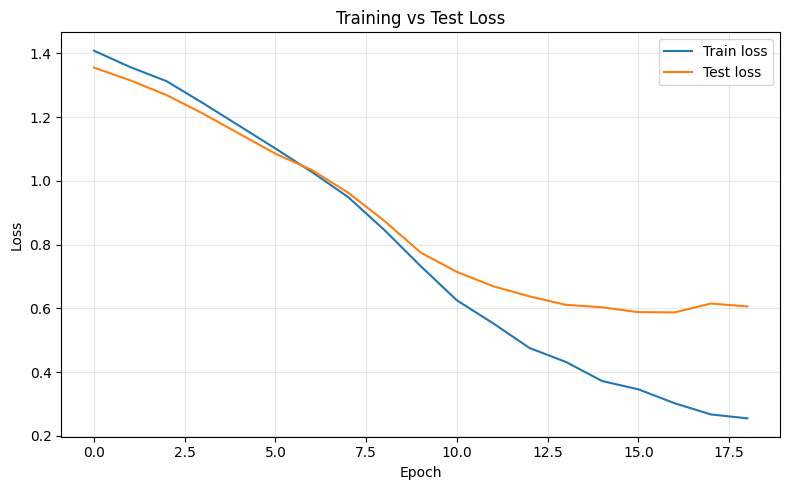

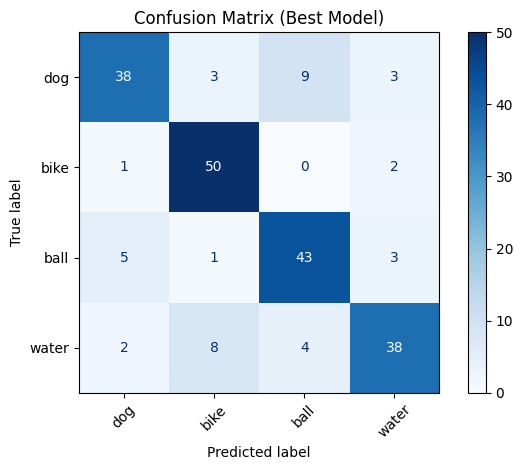

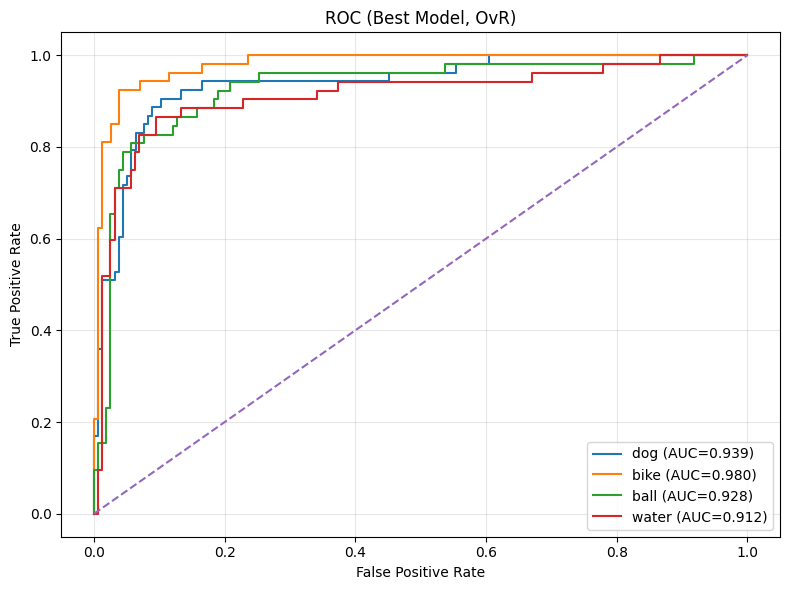

(SmallBERTPourClassification(
   (encoder): SmallBERT(
     (pos_embedding): PositionalEmbedding(
       (token_embeddings): Embedding(1000, 128)
       (position_embeddings): Embedding(70, 128)
     )
     (blocks): ModuleList(
       (0-1): 2 x TransformerBlock(
         (att): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (ffn): Sequential(
           (0): Linear(in_features=128, out_features=256, bias=True)
           (1): ReLU()
           (2): Linear(in_features=256, out_features=128, bias=True)
         )
         (layernorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (layernorm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
     (layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
     (dropout): Dropout(p=0.3, inplace=Fals

In [273]:
fit_text(
    model,
    train_loader,
    test_loader,
    arch="smallbert",
    class_names=["dog", "bike", "ball", "water"],
    num_classes=4,
    lr=1e-4,
    epochs=20
)


Inference: 100%|██████████| 7/7 [00:00<00:00, 57.06it/s]


Accuracy: 0.8286

Classification Report:
              precision    recall  f1-score   support

           0      0.878     0.827     0.851        52
           1      0.836     0.885     0.860        52
           2      0.830     0.830     0.830        53
           3      0.774     0.774     0.774        53

    accuracy                          0.829       210
   macro avg      0.829     0.829     0.829       210
weighted avg      0.829     0.829     0.829       210



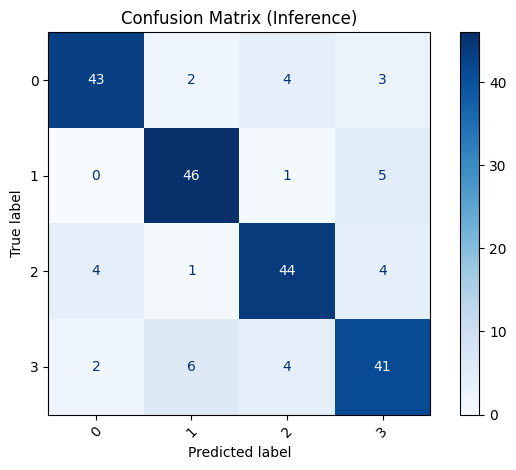

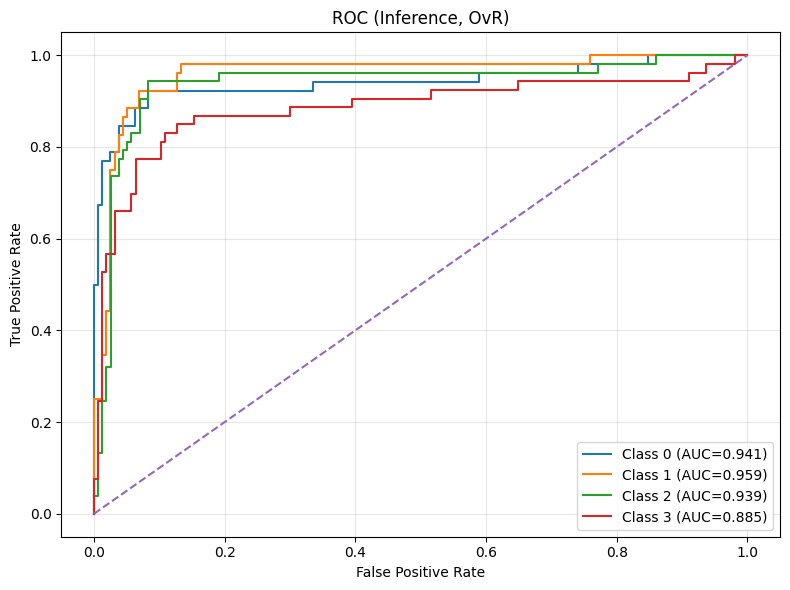

{'acc': 0.8285714387893677,
 'y_true': array([3, 1, 3, 3, 1, 3, 2, 1, 1, 1, 1, 2, 3, 3, 0, 2, 3, 1, 3, 0, 0, 1,
        0, 3, 0, 3, 3, 3, 1, 2, 2, 1, 2, 1, 3, 2, 0, 2, 2, 2, 3, 0, 0, 2,
        0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 2, 1, 3, 0, 3,
        0, 2, 0, 2, 2, 3, 3, 2, 2, 0, 3, 1, 3, 3, 1, 1, 2, 1, 2, 3, 3, 3,
        1, 0, 3, 2, 1, 2, 1, 0, 1, 3, 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 2, 0,
        0, 1, 2, 3, 0, 0, 2, 3, 1, 3, 1, 2, 1, 3, 3, 1, 3, 2, 1, 1, 2, 2,
        0, 1, 2, 1, 3, 0, 0, 3, 1, 1, 0, 0, 0, 0, 2, 3, 2, 1, 1, 0, 3, 3,
        0, 1, 3, 0, 3, 0, 0, 3, 1, 3, 0, 2, 3, 1, 1, 1, 2, 1, 2, 0, 0, 1,
        2, 1, 3, 1, 3, 3, 2, 1, 2, 3, 1, 0, 2, 0, 3, 3, 0, 3, 3, 1, 1, 1,
        2, 2, 1, 2, 2, 3, 0, 2, 0, 3, 1, 3]),
 'y_pred': array([3, 1, 0, 3, 1, 3, 2, 1, 1, 1, 1, 1, 3, 1, 0, 2, 3, 1, 3, 0, 0, 1,
        0, 3, 0, 3, 1, 3, 3, 2, 2, 1, 2, 1, 3, 2, 0, 2, 2, 2, 3, 0, 0, 2,
        1, 0, 0, 0, 1, 1, 0, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 2, 1, 3, 0, 3,
        0, 3, 0, 3

In [282]:
y_train_idx = y_train.apply(lambda x: class_to_idx[x]).astype("int64")
y_val_idx   = y_val.apply(lambda x: class_to_idx[x]).astype("int64")
y_test_idx  = y_test.apply(lambda x: class_to_idx[x]).astype("int64")


val_ds = SmallBertTextDataset(X_val, y_val_idx, tokenizer, MAX_VOCAB, SEQ_LEN)

val_loader = DataLoader(val_ds, batch_size=32)
infer_text_loader(model, val_loader, arch="smallbert")


### DistillBERT

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 [TRAIN]: 100%|██████████| 62/62 [00:06<00:00,  9.28it/s, loss=0.954]



Epoch 1 - Average TRAIN loss: 0.9535


Epoch 1/10 [EVAL]: 100%|██████████| 14/14 [00:00<00:00, 32.42it/s]


Epoch 1 - Average TEST loss: 0.5180 | acc=0.8714

Classification Report:
              precision    recall  f1-score   support

         dog      0.906     0.906     0.906        53
        bike      0.963     0.981     0.972        53
        ball      0.841     0.712     0.771        52
       water      0.780     0.885     0.829        52

    accuracy                          0.871       210
   macro avg      0.872     0.871     0.869       210
weighted avg      0.873     0.871     0.870       210

Nouveau meilleur modèle sauvegardé (test loss: 0.5180)


Epoch 2/10 [TRAIN]: 100%|██████████| 62/62 [00:06<00:00,  9.25it/s, loss=0.288]



Epoch 2 - Average TRAIN loss: 0.2882


Epoch 2/10 [EVAL]: 100%|██████████| 14/14 [00:00<00:00, 32.08it/s]


Epoch 2 - Average TEST loss: 0.3016 | acc=0.8952

Classification Report:
              precision    recall  f1-score   support

         dog      0.918     0.849     0.882        53
        bike      0.945     0.981     0.963        53
        ball      0.849     0.865     0.857        52
       water      0.868     0.885     0.876        52

    accuracy                          0.895       210
   macro avg      0.895     0.895     0.895       210
weighted avg      0.896     0.895     0.895       210

Nouveau meilleur modèle sauvegardé (test loss: 0.3016)


Epoch 3/10 [TRAIN]: 100%|██████████| 62/62 [00:06<00:00,  9.29it/s, loss=0.182]



Epoch 3 - Average TRAIN loss: 0.1819


Epoch 3/10 [EVAL]: 100%|██████████| 14/14 [00:00<00:00, 32.27it/s]


Epoch 3 - Average TEST loss: 0.3363 | acc=0.9048

Classification Report:
              precision    recall  f1-score   support

         dog      0.862     0.943     0.901        53
        bike      0.945     0.981     0.963        53
        ball      0.865     0.865     0.865        52
       water      0.956     0.827     0.887        52

    accuracy                          0.905       210
   macro avg      0.907     0.904     0.904       210
weighted avg      0.907     0.905     0.904       210

Pas d'amélioration (1/2)


Epoch 4/10 [TRAIN]: 100%|██████████| 62/62 [00:06<00:00,  9.28it/s, loss=0.119]



Epoch 4 - Average TRAIN loss: 0.1189


Epoch 4/10 [EVAL]: 100%|██████████| 14/14 [00:00<00:00, 32.25it/s]


Epoch 4 - Average TEST loss: 0.3104 | acc=0.8952

Classification Report:
              precision    recall  f1-score   support

         dog      0.955     0.792     0.866        53
        bike      0.929     0.981     0.954        53
        ball      0.806     0.962     0.877        52
       water      0.917     0.846     0.880        52

    accuracy                          0.895       210
   macro avg      0.902     0.895     0.894       210
weighted avg      0.902     0.895     0.894       210

Pas d'amélioration (2/2)

Early stopping déclenché après 4 époques
Meilleur test loss: 0.3016

Chargement du meilleur modèle (test loss: 0.3016)


Epoch 1/1 [EVAL]:  29%|██▊       | 4/14 [00:00<00:00, 31.69it/s]


--- Mauvaise prédiction (texte) ---
true: dog (0) | pred: ball (2)
text: a dog attempting to chew on a red ball

--- Mauvaise prédiction (texte) ---
true: water (3) | pred: ball (2)
text: in the midst of a rural african village a young man struggles to free himself from the grasp of two stubborn cows that have pulled him into a muddy puddle after crossing a nearby river their hooves leaving deep prints in the wet earth as onlookers gather to watch the commotion the air is thick with ...

--- Mauvaise prédiction (texte) ---
true: water (3) | pred: ball (2)
text: a brown dog playing in mud

--- Mauvaise prédiction (texte) ---
true: water (3) | pred: ball (2)
text: a black dog jumping through some water

--- Mauvaise prédiction (texte) ---
true: water (3) | pred: dog (0)
text: a man uses ice picks and crampons to scale ice


Epoch 1/1 [EVAL]: 100%|██████████| 14/14 [00:00<00:00, 32.13it/s]


Best model - TEST loss: 0.3104 | acc=0.8952


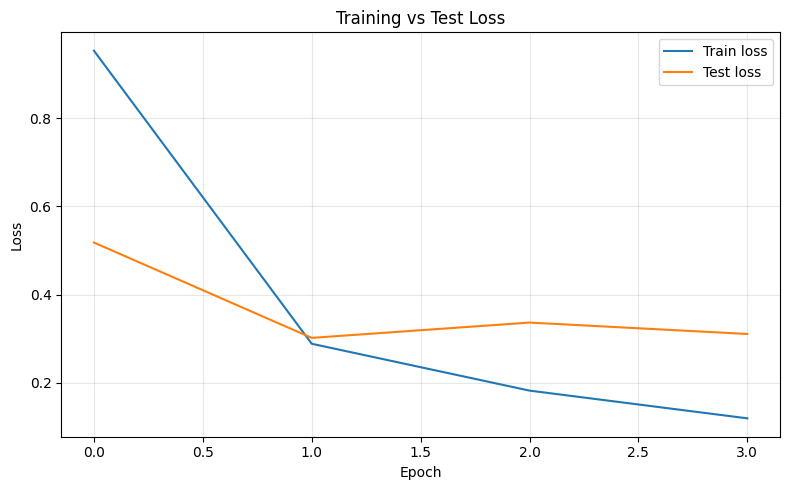

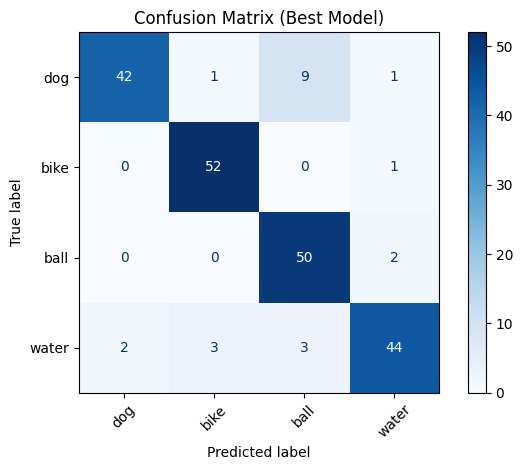

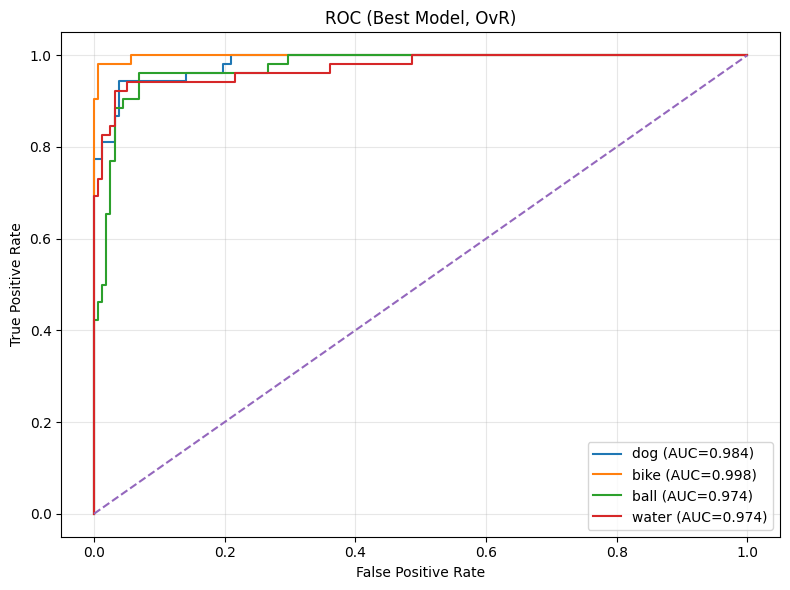

(DistilBertForSequenceClassification(
   (distilbert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0-5): 6 x TransformerBlock(
           (attention): MultiHeadSelfAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=True)
           )
           (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (ffn): FFN(
             (dropout): Dropout(p=

In [284]:
MAX_VOCAB =  1000
OOV_TOKEN = "<OOV>"
SEQ_LEN = 70


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_ds = HFTextDataset(X_train, y_train_idx, tokenizer, max_len=SEQ_LEN)
test_ds  = HFTextDataset(X_test,  y_test_idx,  tokenizer, max_len=SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=16)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4
)

fit_text(
    model,
    train_loader,
    test_loader,
    arch="hf",
    class_names=["dog", "bike", "ball", "water"]
)



### HYBRIS


In [70]:
from typing import Tuple
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class CLIPDataset(Dataset):
    """
    Dataset unifié pour CLIP supportant:
    - Images avec transforms (Visual Classifier)
    - Tokenization Keras (SmallBERT)
    - Tokenization HuggingFace (DistilBERT)
    
    Args:
        df: DataFrame avec colonnes 'image_path', 'label', 'caption'
        base_dir: Répertoire de base pour les images
        transform: Transformations d'image (torchvision)
        keras_tokenizer: Tokenizer Keras (optionnel, pour SmallBERT)
        hf_tokenizer: Tokenizer HuggingFace (optionnel, pour DistilBERT)
        max_seq_len: Longueur max des séquences
        vocab_size: Taille du vocabulaire pour Keras tokenizer
        text_mode: 'keras', 'hf', ou 'both' pour le type de tokenization
    """
    
    def __init__(
        self,
        df,
        base_dir: Path,
        transform,
        keras_tokenizer=None,
        hf_tokenizer=None,
        max_seq_len: int = 64,
        vocab_size: int = 1000,
        text_mode: str = "keras"  # 'keras', 'hf', ou 'both'
    ):
        self.base_dir = Path(base_dir)
        self.transform = transform
        self.max_seq_len = max_seq_len
        self.vocab_size = 1000
        self.text_mode = text_mode
        
        # Données du DataFrame
        self.img_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()
        self.captions = df["caption"].tolist()
        
        # Mapping des classes
        self.classes = sorted(set(self.labels))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.num_classes = len(self.classes)
        
        # Tokenizers
        self.keras_tokenizer = keras_tokenizer
        self.hf_tokenizer = hf_tokenizer
        
        # Setup OOV pour Keras
        if self.keras_tokenizer is not None:
            oov_tok = getattr(self.keras_tokenizer, "oov_token", "<OOV>")
            self.oov_id = self.keras_tokenizer.word_index.get(oov_tok, 1)
            if self.oov_id is None or self.oov_id >= self.vocab_size:
                self.oov_id = 1
        
        # Validation
        self._validate_tokenizers()
    
    def _validate_tokenizers(self):
        """Valide que les tokenizers nécessaires sont fournis"""
        if self.text_mode in ["keras", "both"] and self.keras_tokenizer is None:
            raise ValueError("keras_tokenizer requis pour text_mode='keras' ou 'both'")
        if self.text_mode in ["hf", "both"] and self.hf_tokenizer is None:
            raise ValueError("hf_tokenizer requis pour text_mode='hf' ou 'both'")
    
    def _build_image_path(self, img_path: str) -> Path:
        """Construit le chemin complet de l'image"""
        return Path(build_augmented_path(img_path, self.base_dir))
    
    def _tokenize_keras(self, text: str) -> torch.Tensor:
        """Tokenization style SmallBERT (Keras)"""
        seq = self.keras_tokenizer.texts_to_sequences([text])[0]
        # Remplace les tokens hors vocab par OOV
        seq = [
            t if (t is not None and 0 <= t < self.vocab_size) else self.oov_id
            for t in seq
        ]
        # Padding
        padded = pad_sequences(
            [seq],
            maxlen=self.max_seq_len,
            padding="post",
            truncating="post",
            value=0
        )[0].astype(np.int64)
        
        return torch.tensor(padded, dtype=torch.long)
    
    def _tokenize_hf(self, text: str) -> dict:
        """Tokenization style DistilBERT (HuggingFace)"""
        enc = self.hf_tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_seq_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0).to(torch.long),
            "attention_mask": enc["attention_mask"].squeeze(0).to(torch.long)
        }
    
    def __getitem__(self, idx: int) -> dict:
        # === IMAGE ===
        img_path = self._build_image_path(self.img_paths[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        
        # === CAPTION ===
        caption = str(self.captions[idx])
        
        # === LABEL ===
        label_str = self.labels[idx]
        label = torch.tensor(self.class_to_idx[label_str], dtype=torch.long)
        
        # === OUTPUT DICT ===
        output = {
            "idx": torch.tensor(idx, dtype=torch.long),
            "image": img,
            "label": label,
            "caption": caption,
        }
        
        # Tokenization selon le mode
        if self.text_mode in ["keras", "both"]:
            input_ids_keras = self._tokenize_keras(caption)
            output["input_ids_keras"] = input_ids_keras
            output["attention_mask_keras"] = (input_ids_keras != 0).long()
            
            # Pour compatibilité avec l'ancien format
            if self.text_mode == "keras":
                output["input_ids"] = input_ids_keras
                output["attention_mask"] = output["attention_mask_keras"]
        
        if self.text_mode in ["hf", "both"]:
            hf_tokens = self._tokenize_hf(caption)
            output["input_ids_hf"] = hf_tokens["input_ids"]
            output["attention_mask_hf"] = hf_tokens["attention_mask"]
            
            # Pour compatibilité avec l'ancien format
            if self.text_mode == "hf":
                output["input_ids"] = hf_tokens["input_ids"]
                output["attention_mask"] = hf_tokens["attention_mask"]
        
        return output
    
    def __len__(self) -> int:
        return len(self.img_paths)
    
    # === Méthodes utilitaires (compatibilité ImageCLIPDataset) ===
    
    def _get_img_path_from_idx(self, idx: int) -> Path:
        return self._build_image_path(self.img_paths[idx])
    
    def _get_caption_from_idx(self, idx: int) -> str:
        return self.captions[idx]
    
    def _get_label_from_idx(self, idx: int) -> str:
        return self.labels[idx]
    
    def _get_img_size(self, idx: int) -> Tuple[int, int]:
        img_path = self._build_image_path(self.img_paths[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            for t in self.transform.transforms:
                if isinstance(t, transforms.Resize):
                    img = t(img)
        return img.height, img.width

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageEncoderFromCNNBasic(nn.Module):
    def __init__(self, cnn_basic: nn.Module, embed_dim: int = 256, proj_dim: int = 256):
        super().__init__()
        # on réutilise les features
        self.features = cnn_basic.features

        # au lieu de classifier -> on sort un embedding
        self.flattened_size = cnn_basic.flattened_size
        self.backbone_fc = nn.Sequential(
            nn.Linear(self.flattened_size, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        # projection CLIP (souvent un petit MLP)
        self.proj = nn.Sequential(
            nn.Linear(embed_dim, proj_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.backbone_fc(x)
        x = self.proj(x)
        x = F.normalize(x, dim=-1)
        return x


In [ ]:
class TextEncoderFromSmallBERT(nn.Module):
    def __init__(self, text_model: nn.Module, proj_dim: int = 256):
        super().__init__()
        self.encoder = text_model.encoder  # SmallBERT(...)
        self.dropout = nn.Dropout(0.1)

        # embed_dim = dimension de sortie de SmallBERT
        # on la récupère via le classifier existant si besoin
        embed_dim = text_model.classifier.in_features

        self.proj = nn.Linear(embed_dim, proj_dim)

    def forward(self, x, padding_mask=None):
        enc = self.encoder(x)  # (B, L, D)
        pooled = enc.mean(dim=1)
        pooled = self.dropout(pooled)
        z = self.proj(pooled)
        z = F.normalize(z, dim=-1)
        return z


In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

class ImageEncoderFromResNet18(nn.Module):
    def __init__(self, resnet: nn.Module, proj_dim: int = 256, train_backbone: bool = True):
        super().__init__()
        self.backbone = resnet

        # IMPORTANT: on retire la couche de classification
        # resnet.fc.in_features = 512 pour ResNet18
        self.backbone.fc = nn.Identity()

        # projection vers l'espace commun CLIP
        self.proj = nn.Linear(512, proj_dim)

        if not train_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # backbone -> (B,512)
        feats = self.backbone(x)
        z = self.proj(feats)
        return F.normalize(z, dim=-1)
def load_best_resnet18(num_classes=4, ckpt_path="best-model-resnet.pth", device="cpu"):
    model = resnet18(weights=None)  # weights=None car on charge tes poids
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    ckpt = torch.load(ckpt_path, map_location=device)
    state = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt
    model.load_state_dict(state, strict=True)
    return model


In [10]:
class CLIPLikeModel(nn.Module):
    def __init__(self, image_encoder: nn.Module, text_encoder: nn.Module, init_logit_scale=1/0.07):
        super().__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.logit_scale = nn.Parameter(torch.tensor(float(torch.log(torch.tensor(init_logit_scale)))))

    def forward(self, images, tokens, padding_mask=None):
        img = self.image_encoder(images)                   # (B, D)
        txt = self.text_encoder(tokens, padding_mask)      # (B, D)
        logit_scale = self.logit_scale.exp().clamp(1e-3, 100.0)
        logits = logit_scale * (img @ txt.t())             # (B, B)
        return logits, img, txt


def clip_contrastive_loss(logits):
    # labels = indices diagonale: i doit matcher i
    b = logits.size(0)
    labels = torch.arange(b, device=logits.device)

    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.t(), labels)
    return (loss_i2t + loss_t2i) / 2


In [11]:
def load_model_weights(model: nn.Module, ckpt_path: str, strict: bool = True):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    state = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt
    model.load_state_dict(state, strict=strict)
    return model


In [12]:
def load_without_classifier(model: nn.Module, ckpt_path: str, classifier_prefix="classifier.", map_location="cpu"):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    state = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt

    filtered = {k: v for k, v in state.items() if not k.startswith(classifier_prefix)}
    missing, unexpected = model.load_state_dict(filtered, strict=False)
    print("Missing:", missing)
    print("Unexpected:", unexpected)
    return model


In [13]:
class CNNBasic(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2,2)
        )

        self.flattened_size = self._get_flattened_size()

        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 300, 500)
            x = self.features(x)
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [14]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout_rate: float = 0.1) -> None:
        super().__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor, padding_mask: torch.Tensor = None) -> torch.Tensor:
        attn_output, _ = self.att(
            x, x, x,
            key_padding_mask=padding_mask  # <-- correct masking
        )

        x = self.layernorm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(x)
        out = self.layernorm2(x + self.dropout2(ffn_output))
        return out
class SmallBERT(nn.Module):
    def __init__(self, sequence_length: int, vocab_size: int, embed_dim: int,
                 num_heads: int, ff_dim: int, num_layers: int) -> None:
        super().__init__()
        self.pos_embedding = PositionalEmbedding(sequence_length, vocab_size, embed_dim)
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim)
            for _ in range(num_layers)
        ])
        self.layernorm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, seq_len) token ids
        """
        padding_mask = (x == 0)  # 0 = PAD  -> True masked in attn
        x = self.pos_embedding(x)

        for block in self.blocks:
            x = block(x, padding_mask=padding_mask)

        x = self.layernorm(x)
        return self.dropout(x)
class PositionalEmbedding(nn.Module):
    def __init__(self, sequence_length: int, vocab_size:int, embed_dim:int):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_embeddings = nn.Embedding(sequence_length, embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        return self.token_embeddings(x) + self.position_embeddings(positions)

class SmallBERTPourClassification(nn.Module):
    def __init__(self, sequence_length: int, vocab_size: int, embed_dim: int,
                 num_heads: int, ff_dim: int, num_layers: int,
                 num_classes: int = 4) -> None:
        super().__init__()

        self.encoder = SmallBERT(sequence_length, vocab_size, embed_dim, num_heads, ff_dim, num_layers)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        enc = self.encoder(x)             # (batch, seq_len, embed_dim)
        pooled = enc.mean(dim=1)          # mean pooling
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return logits  # logits only, pas softmax


In [20]:
# 1) reconstruire tes archis d'origine
cnn_basic = CNNBasic(num_classes=4)

text_cls = SmallBERTPourClassification(
    vocab_size=1000,      # DOIT matcher les ids de tokens
    sequence_length=128,   # DOIT matcher la longueur des séquences
    embed_dim=128,
    num_heads=4,
    ff_dim=256,
    num_layers=2,
    num_classes=4
)

# 2) charger les poids (souvent strict=True si archi identique)
cnn_basic = load_model_weights(cnn_basic, "../models/best-model-ccnbasic.pth", strict=True)
text_cls  = load_model_weights(text_cls,  "../models/best-model-smallbert.pth", strict=True)

# 3) convertir en encodeurs CLIP
img_encoder = ImageEncoderFromCNNBasic(cnn_basic, embed_dim=256, proj_dim=256)
txt_encoder = TextEncoderFromSmallBERT(text_cls, proj_dim=256)

clip_model = CLIPLikeModel(img_encoder, txt_encoder)


In [21]:
def train_step(batch, model, optimizer, device="cuda"):
    images, tokens = batch  # + éventuellement padding_mask
    images = images.to(device)
    tokens = tokens.to(device)

    model.train()
    optimizer.zero_grad()

    logits, _, _ = model(images, tokens)
    loss = clip_contrastive_loss(logits)

    loss.backward()
    optimizer.step()
    return loss.item()


In [38]:
def clip_collate_keras(batch):
    images = torch.stack([b["image"] for b in batch], dim=0)  # (B,3,H,W)
    input_ids = torch.stack([b["input_ids"] for b in batch], dim=0)  # (B,L)
    attention_mask = torch.stack([b["attention_mask"] for b in batch], dim=0)  # (B,L)
    labels = torch.stack([b["label"] for b in batch], dim=0)  # (B,)
    idx = torch.stack([b["idx"] for b in batch], dim=0)  # (B,)
    return {"images": images, "input_ids": input_ids, "attention_mask": attention_mask, "labels": labels, "idx": idx}


In [74]:
import torch
import torch.nn.functional as F

def clip_contrastive_loss(logits):
    b = logits.size(0)
    labels = torch.arange(b, device=logits.device)
    return (F.cross_entropy(logits, labels) + F.cross_entropy(logits.t(), labels)) / 2
def train_step(batch, model, optimizer, device="cuda"):
    images = batch["images"].to(device)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    # True = PAD pour MultiheadAttention
    padding_mask = (attention_mask == 0)

    model.train()
    optimizer.zero_grad(set_to_none=True)

    logits, _, _ = model(images, input_ids, padding_mask=padding_mask)
    loss = clip_contrastive_loss(logits)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    return loss.item()
@torch.no_grad()
def val_step(batch, model, device="cuda"):
    images = batch["images"].to(device)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    padding_mask = (attention_mask == 0)

    model.eval()
    logits, _, _ = model(images, input_ids, padding_mask=padding_mask)
    loss = clip_contrastive_loss(logits)
    return loss.item()
from tqdm import tqdm

def fit(model, train_loader, val_loader, optimizer, epochs=10, device="cuda"):
    model.to(device)

    for epoch in range(1, epochs + 1):
        train_losses = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
            train_losses.append(train_step(batch, model, optimizer, device))

        val_losses = []
        for batch in tqdm(val_loader, desc=f"Epoch {epoch} [val]"):
            val_losses.append(val_step(batch, model, device))

        print(
            f"Epoch {epoch} | "
            f"train_loss={sum(train_losses)/len(train_losses):.4f} | "
            f"val_loss={sum(val_losses)/len(val_losses):.4f}"
        )
base_dir = Path("../data/final_dataset_noaug2")

transform = transforms.Compose(
    [transforms.Resize((300, 500)),
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000, oov_token="<OVV>")
tokenizer.fit_on_texts(df["caption"])

train_ds = CLIPDataset(df_train, base_dir=base_dir, transform=transform,
                       keras_tokenizer=tokenizer, max_seq_len=64,
                       vocab_size=1000, text_mode="keras")

val_ds = CLIPDataset(df_val, base_dir=base_dir, transform=transform,
                     keras_tokenizer=tokenizer, max_seq_len=64,
                     vocab_size=1000, text_mode="keras")

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4,
                          pin_memory=True, collate_fn=clip_collate_keras)

val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4,
                        pin_memory=True, collate_fn=clip_collate_keras)


In [75]:
img_encoder = ImageEncoderFromCNNBasic(cnn_basic, embed_dim=256, proj_dim=256)
txt_encoder = TextEncoderFromSmallBERT(text_cls, proj_dim=256)
clip_model = CLIPLikeModel(img_encoder, txt_encoder)

def set_trainable(m, flag: bool):
    for p in m.parameters():
        p.requires_grad = flag

# Freeze backbones (features CNN + encoder texte)
set_trainable(clip_model.image_encoder.features, False)
set_trainable(clip_model.text_encoder.encoder, False)


In [ ]:

import numpy as np
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, clip_model.parameters()),
    lr=1e-3, weight_decay=1e-4
)

fit(clip_model, train_loader, val_loader, optimizer, epochs=3, device=device)


Epoch 1 [val]: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


Epoch 1 | train_loss=3.3865 | val_loss=3.9958


Epoch 2 [val]: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


Epoch 2 | train_loss=2.7379 | val_loss=4.5943


Epoch 3 [val]: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

Epoch 3 | train_loss=2.4015 | val_loss=4.6447


In [87]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def encode_text_keras(tokenizer, text: str, max_seq_len=64, vocab_size=1000, oov_id=1):
    seq = tokenizer.texts_to_sequences([text])[0]
    seq = [t if (t is not None and 0 <= t < vocab_size) else oov_id for t in seq]

    padded = pad_sequences(
        [seq], maxlen=max_seq_len, padding="post", truncating="post", value=0
    )[0].astype(np.int64)

    input_ids = torch.tensor(padded, dtype=torch.long).unsqueeze(0)      # (1,L)
    attention_mask = (input_ids != 0).long()                             # (1,L)
    padding_mask = (attention_mask == 0)                                 # (1,L) bool
    return input_ids, padding_mask

@torch.no_grad()
def show_retrieval_from_text(
    clip_model,
    index,
    query_text: str,
    tokenizer,
    max_seq_len=64,
    vocab_size=1000,
    oov_id=1,
    topk=5,
    device="cuda",
    show_images=True
):
    """
    Donne une phrase -> retourne topk images (paths + scores) et optionnellement les affiche.
    """
    clip_model.eval()
    clip_model.to(device)

    input_ids, padding_mask = encode_text_keras(
        tokenizer, query_text, max_seq_len=max_seq_len,
        vocab_size=vocab_size, oov_id=oov_id
    )
    input_ids = input_ids.to(device)
    padding_mask = padding_mask.to(device)

    q = clip_model.text_encoder(input_ids, padding_mask)   # (1,D)
    q = F.normalize(q, dim=-1).cpu()                       # (1,D)

    # Similarité cosine = dot produit car embeddings normalisés
    sims = (index["img_embs"] @ q.squeeze(0))              # (N,)
    topv, topi = torch.topk(sims, k=min(topk, sims.size(0)))

    results = []
    for score, idx in zip(topv.tolist(), topi.tolist()):
        path = index["image_paths"][idx] if index["image_paths"] is not None else None
        cap = index["captions"][idx] if index["captions"] is not None else None
        results.append({"rank": len(results)+1, "score": float(score), "image_path": path, "caption": cap})

    print(f"Query text: {query_text}\nTop-{len(results)} images:")
    for r in results:
        print(f"#{r['rank']} score={r['score']:.4f} | {r['image_path']}")

    if show_images and index["image_paths"] is not None:
        fig = plt.figure(figsize=(14, 6))
        for j, r in enumerate(results):
            ax = fig.add_subplot(1, len(results), j+1)
            img = Image.open(r["image_path"]).convert("RGB")
            ax.imshow(img)
            ax.set_title(f"#{r['rank']}\n{r['score']:.3f}")
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    return results


In [88]:
@torch.no_grad()
def show_retrieval_from_image(
    clip_model,
    index,
    query_image,            # str path OR PIL.Image OR torch.Tensor (3,H,W)
    transform=None,         # même transform que ton dataset
    topk=5,
    device="cuda",
    show=True
):
    """
    Donne une image -> retourne topk captions (et leurs images associées si disponibles).
    """
    clip_model.eval()
    clip_model.to(device)

    # Prépare tensor image (1,3,H,W)
    if isinstance(query_image, str):
        img = Image.open(query_image).convert("RGB")
        x = transform(img) if transform is not None else img
    elif isinstance(query_image, Image.Image):
        x = transform(query_image) if transform is not None else query_image
    elif torch.is_tensor(query_image):
        x = query_image
    else:
        raise TypeError("query_image doit être un chemin, une PIL.Image, ou un torch.Tensor.")

    if not torch.is_tensor(x):
        raise ValueError("transform doit retourner un torch.Tensor (3,H,W).")

    x = x.unsqueeze(0).to(device)  # (1,3,H,W)

    q = clip_model.image_encoder(x)          # (1,D)
    q = F.normalize(q, dim=-1).cpu()         # (1,D)

    sims = (index["txt_embs"] @ q.squeeze(0))   # (N,)
    topv, topi = torch.topk(sims, k=min(topk, sims.size(0)))

    results = []
    for score, idx in zip(topv.tolist(), topi.tolist()):
        cap = index["captions"][idx] if index["captions"] is not None else None
        path = index["image_paths"][idx] if index["image_paths"] is not None else None
        results.append({"rank": len(results)+1, "score": float(score), "caption": cap, "image_path": path})

    print("Top captions:")
    for r in results:
        print(f"#{r['rank']} score={r['score']:.4f} | {r['caption']}")

    if show:
        # affiche la query image + top images (si dispo)
        fig = plt.figure(figsize=(14, 6))
        ax0 = fig.add_subplot(1, len(results)+1, 1)
        # query image pour affichage
        if isinstance(query_image, str):
            qimg = Image.open(query_image).convert("RGB")
        elif isinstance(query_image, Image.Image):
            qimg = query_image
        else:
            # tensor -> convert approx
            qimg = None
        if qimg is not None:
            ax0.imshow(qimg)
        ax0.set_title("QUERY")
        ax0.axis("off")

        if index["image_paths"] is not None:
            for j, r in enumerate(results):
                ax = fig.add_subplot(1, len(results)+1, j+2)
                img = Image.open(r["image_path"]).convert("RGB")
                ax.imshow(img)
                title = f"#{r['rank']} {r['score']:.3f}"
                ax.set_title(title)
                ax.axis("off")

        plt.tight_layout()
        plt.show()

    return results


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

@torch.no_grad()
def build_clip_index(clip_model, dataloader, device="cuda"):
    """
    Calcule embeddings normalisés pour tout le dataset du dataloader.
    Retourne un dict contenant:
      - img_embs: (N,D)
      - txt_embs: (N,D)
      - image_paths: list[str]  (si dispo)
      - captions: list[str]     (si dispo)
      - labels: list[int]       (si dispo)
    """
    clip_model.eval()
    clip_model.to(device)

    img_embs = []
    txt_embs = []
    captions = []
    labels = []
    idxs = []

    # Si ton dataset est CLIPDataset, on peut récupérer chemin/caption via idx
    ds = dataloader.dataset
    has_utils = hasattr(ds, "_get_img_path_from_idx") and hasattr(ds, "_get_caption_from_idx")

    for batch in tqdm(dataloader, desc="Building CLIP index"):
        images = batch["images"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        padding_mask = (attention_mask == 0)

        # embeddings
        im = clip_model.image_encoder(images)                         # (B,D) déjà normalize si tu l'as fait
        tx = clip_model.text_encoder(input_ids, padding_mask)         # (B,D)

        # sécurité
        im = F.normalize(im, dim=-1)
        tx = F.normalize(tx, dim=-1)

        img_embs.append(im.cpu())
        txt_embs.append(tx.cpu())

        if "idx" in batch:
            idx_batch = batch["idx"].cpu().tolist()
            idxs.extend(idx_batch)

            if has_utils:
                for i in idx_batch:
                    captions.append(str(ds._get_caption_from_idx(i)))
        if "labels" in batch:
            labels.extend(batch["labels"].cpu().tolist())

    img_embs = torch.cat(img_embs, dim=0)   # (N,D)
    txt_embs = torch.cat(txt_embs, dim=0)   # (N,D)

    image_paths = None
    if has_utils and len(idxs) == img_embs.size(0):
        image_paths = [str(ds._get_img_path_from_idx(i)) for i in idxs]

    return {
        "img_embs": img_embs,
        "txt_embs": txt_embs,
        "image_paths": image_paths,
        "captions": captions if len(captions) == img_embs.size(0) else None,
        "labels": labels if len(labels) == img_embs.size(0) else None,
    }


In [ ]:
index_val = build_clip_index(clip_model, val_loader, device=device)


Building CLIP index: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Query text: the man playing with a ball
Top-5 images:
#1 score=0.5490 | ../data/final_dataset_noaug2/base_ball/ball_126/base_ball_126.jpg
#2 score=0.4849 | ../data/final_dataset_noaug2/base_bike/bike_051/base_bike_051.jpg
#3 score=0.4736 | ../data/final_dataset_noaug2/new_water/water_601/new_water_601.jpg
#4 score=0.4582 | ../data/final_dataset_noaug2/base_ball/ball_145/base_ball_145.jpg
#5 score=0.4526 | ../data/final_dataset_noaug2/base_ball/ball_135/base_ball_135.jpg


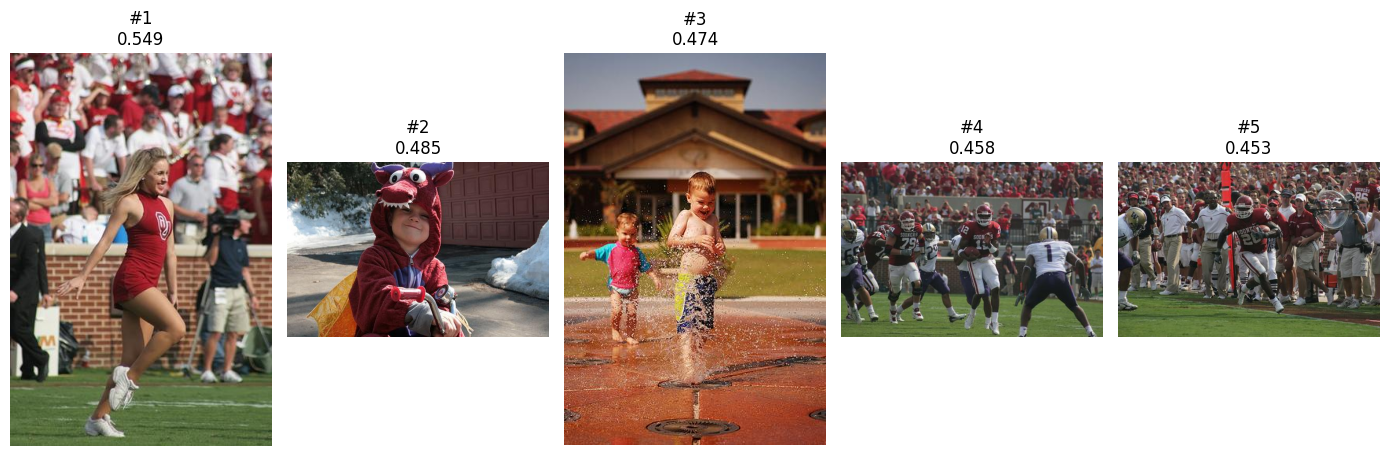

In [107]:
res = show_retrieval_from_text(
    clip_model, index_val,
    query_text="the man playing with a ball",
    tokenizer=tokenizer,
    max_seq_len=64, vocab_size=1000, oov_id=1,
    topk=5, device=device, show_images=True
)


In [98]:
val_ds._get_img_path_from_idx(1)
    


PosixPath('../data/final_dataset_noaug2/new_bike/bike_225/new_bike_225.jpg')

Top captions:
#1 score=0.4161 | A young girl, laughing with joy, runs along the shoreline, her long hair blowing in the ocean breeze as she playfully chases after a seagull. The warm sunlight casts a golden glow on the sand and the gentle waves of the sea lap at the shore, creating a soothing melody that fills the air. In the distance, sailboats bob gently on the horizon, their white sails billowing in the wind.
#2 score=0.4135 | A young boy, dressed in a bright striped shirt, leaps into the air with joy, his outstretched arms waving as he plays in front of a tranquil water fountain. The soft mist created by the gently flowing water rises into the warm sunlight, casting a serene atmosphere around the lively scene. In the background, a few trees provide a subtle backdrop to the boy's carefree moment, their leaves rustling softly in the breeze.
#3 score=0.4094 | The boy swims effortlessly through the crystal-clear waters of the coral reef, his bright orange snorkel mask allowing him to b

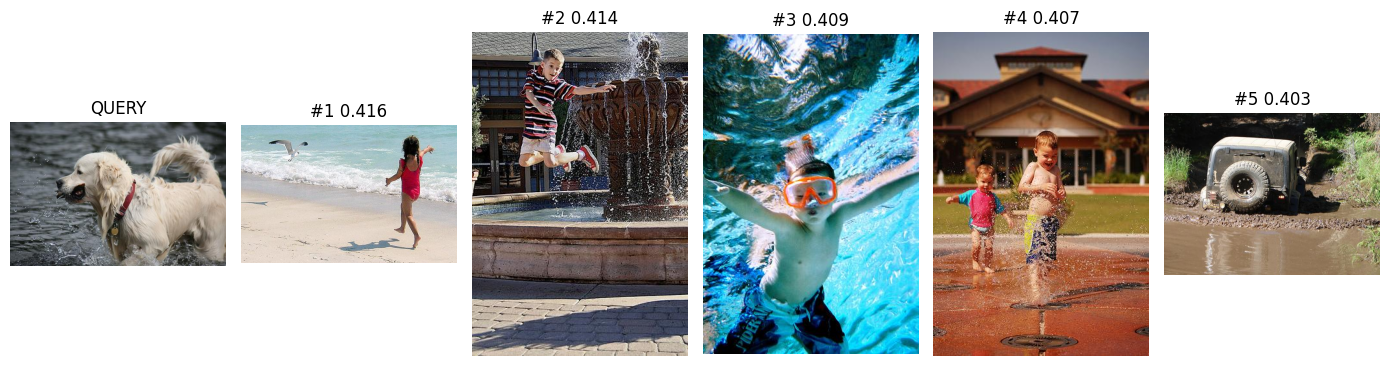

In [109]:
res = show_retrieval_from_image(
    clip_model, index_val,
    query_image=str(val_ds._get_img_path_from_idx(121
)),  # ou un chemin externe
    transform=transform,
    topk=5, device=device, show=True
)


In [120]:
import torch.nn as nn
import torch.nn.functional as F

class TextEncoderFromDistilBERT(nn.Module):
    def __init__(self, distilbert_cls_model, proj_dim=256):
        super().__init__()
        # backbone (DistilBERTModel)
        self.backbone = distilbert_cls_model.distilbert
        hidden = self.backbone.config.hidden_size
        self.proj = nn.Linear(hidden, proj_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        h = out.last_hidden_state  # (B,L,H)

        # mean pooling masqué
        mask = attention_mask.unsqueeze(-1).float()          # (B,L,1)
        summed = (h * mask).sum(dim=1)                       # (B,H)
        denom = mask.sum(dim=1).clamp(min=1e-6)              # (B,1)
        pooled = summed / denom                              # (B,H)

        pooled = self.dropout(pooled)
        z = self.proj(pooled)
        return F.normalize(z, dim=-1)
class CLIPLikeModelHF(nn.Module):
    def __init__(self, image_encoder, text_encoder, init_temp=0.07):
        super().__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.logit_scale = nn.Parameter(torch.log(torch.tensor(1.0/init_temp)))

    def forward(self, images, input_ids, attention_mask):
        img = self.image_encoder(images)                         # (B,D)
        txt = self.text_encoder(input_ids, attention_mask)       # (B,D)
        scale = self.logit_scale.exp().clamp(1e-3, 100.0)
        logits = scale * (img @ txt.t())
        return logits, img, txt
def train_step_hf(batch, model, optimizer, device="cuda"):
    images = batch["images"].to(device)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    model.train()
    optimizer.zero_grad(set_to_none=True)

    logits, _, _ = model(images, input_ids, attention_mask=attention_mask)
    loss = clip_contrastive_loss(logits)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    return loss.item()

@torch.no_grad()
def val_step_hf(batch, model, device="cuda"):
    images = batch["images"].to(device)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    model.eval()
    logits, _, _ = model(images, input_ids, attention_mask=attention_mask)
    loss = clip_contrastive_loss(logits)
    return loss.item()

def fit_hf(model, train_loader, val_loader, optimizer, epochs=10, device="cuda"):
    model.to(device)

    for epoch in range(1, epochs + 1):
        train_losses = []
        for batch in train_loader:
            train_losses.append(train_step_hf(batch, model, optimizer, device))

        val_losses = []
        for batch in val_loader:
            val_losses.append(val_step_hf(batch, model, device))

        print(f"Epoch {epoch} | train_loss={sum(train_losses)/len(train_losses):.4f} | val_loss={sum(val_losses)/len(val_losses):.4f}")



In [111]:
def clip_collate(batch):
    """
    batch: list[dict] venant de CLIPDataset.__getitem__()
    Retourne un dict batché: images, input_ids, attention_mask, labels, idx
    """
    images = torch.stack([b["image"] for b in batch], dim=0)  # (B,3,H,W)
    input_ids = torch.stack([b["input_ids"] for b in batch], dim=0)  # (B,L)
    attention_mask = torch.stack([b["attention_mask"] for b in batch], dim=0)  # (B,L)

    labels = torch.stack([b["label"] for b in batch], dim=0) if "label" in batch[0] else None
    idx = torch.stack([b["idx"] for b in batch], dim=0) if "idx" in batch[0] else None

    out = {
        "images": images,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
    }
    if labels is not None:
        out["labels"] = labels
    if idx is not None:
        out["idx"] = idx
    return out


In [115]:
import torch
from transformers import AutoModelForSequenceClassification

def load_hf_classifier_checkpoint(model, ckpt_path, map_location="cpu"):
    ckpt = torch.load(ckpt_path, map_location=map_location)

    # cas 1: state_dict direct
    if isinstance(ckpt, dict) and any(k.startswith("distilbert.") or k.startswith("classifier.") for k in ckpt.keys()):
        state = ckpt
    # cas 2: dict avec clés
    elif isinstance(ckpt, dict) and "state_dict" in ckpt:
        state = ckpt["state_dict"]
    elif isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        state = ckpt["model_state_dict"]
    else:
        raise ValueError("Format checkpoint non reconnu")

    missing, unexpected = model.load_state_dict(state, strict=False)
    print("Missing:", missing)
    print("Unexpected:", unexpected)
    return model
MODEL_NAME = "distilbert-base-uncased"
distilbert_cls = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)
distilbert_cls = load_hf_classifier_checkpoint(distilbert_cls, "../models/best-distilbert.pth")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Missing: []
Unexpected: []


In [117]:
MODEL_NAME = "distilbert-base-uncased"   # si captions FR => plutôt distilbert-base-multilingual-cased
from transformers import AutoTokenizer

hf_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = CLIPDataset(df_train, base_dir=base_dir, transform=transform,
                       hf_tokenizer=hf_tokenizer, max_seq_len=128,
                       text_mode="hf")

val_ds = CLIPDataset(df_val, base_dir=base_dir, transform=transform,
                     hf_tokenizer=hf_tokenizer, max_seq_len=128,
                     text_mode="hf")

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,
                          num_workers=4, pin_memory=True,
                          collate_fn=clip_collate)

val_loader = DataLoader(val_ds, batch_size=64, shuffle=False,
                        num_workers=4, pin_memory=True,
                        collate_fn=clip_collate)


In [129]:
# image encoder (comme avant)
img_encoder = ImageEncoderFromCNNBasic(cnn_basic, embed_dim=256, proj_dim=256)

# texte encoder distilbert
txt_encoder = TextEncoderFromDistilBERT(distilbert_cls, proj_dim=256)

clip_model = CLIPLikeModelHF(img_encoder, txt_encoder, init_temp=0.07)

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)
def set_trainable(m, flag: bool):
    for p in m.parameters():
        p.requires_grad = flag

# Freeze CNN features + distilbert backbone au début
set_trainable(clip_model.image_encoder.features, False)
set_trainable(clip_model.text_encoder.backbone, False)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, clip_model.parameters()),
                              lr=1e-3, weight_decay=1e-4)

# fit version HF (en appelant train_step_hf/val_step_hf)
set_trainable(clip_model.image_encoder.features, True)
set_trainable(clip_model.text_encoder.backbone, True)

optimizer = torch.optim.AdamW(clip_model.parameters(), lr=1e-4, weight_decay=1e-4)


In [131]:

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
fit_hf(clip_model, train_loader, val_loader, optimizer, epochs=11, device=device)


Epoch 1 | train_loss=3.2966 | val_loss=3.4230
Epoch 2 | train_loss=2.4270 | val_loss=3.7000
Epoch 3 | train_loss=1.6580 | val_loss=3.7501
Epoch 4 | train_loss=1.1710 | val_loss=4.1078


KeyboardInterrupt: 

In [133]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

@torch.no_grad()
def build_clip_index_hf(clip_model, dataloader, device="cuda"):
    clip_model.eval()
    clip_model.to(device)

    img_embs, txt_embs = [], []
    captions, image_paths, labels = [], [], []

    ds = dataloader.dataset
    has_utils = hasattr(ds, "_get_img_path_from_idx") and hasattr(ds, "_get_caption_from_idx")

    for batch in tqdm(dataloader, desc="Building CLIP index (HF)"):
        images = batch["images"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        img = F.normalize(clip_model.image_encoder(images), dim=-1)               # (B,D)
        txt = F.normalize(clip_model.text_encoder(input_ids, attention_mask), dim=-1)

        img_embs.append(img.cpu())
        txt_embs.append(txt.cpu())

        if "labels" in batch:
            labels.extend(batch["labels"].cpu().tolist())

        if "idx" in batch and has_utils:
            for i in batch["idx"].cpu().tolist():
                image_paths.append(str(ds._get_img_path_from_idx(i)))
                captions.append(str(ds._get_caption_from_idx(i)))

    return {
        "img_embs": torch.cat(img_embs, dim=0),   # (N,D)
        "txt_embs": torch.cat(txt_embs, dim=0),   # (N,D)
        "image_paths": image_paths if len(image_paths) else None,
        "captions": captions if len(captions) else None,
        "labels": labels if len(labels) else None,
    }


In [134]:
import torch

@torch.no_grad()
def recall_at_k_from_sims(sims: torch.Tensor, ks=(1,5,10)):
    """
    sims: (N,N) où sims[i,j] = similarité query i avec target j
    Ground-truth = j == i
    """
    N = sims.size(0)
    gt = torch.arange(N, device=sims.device).unsqueeze(1)  # (N,1)

    # ranks = indices triés décroissants
    ranks = torch.argsort(sims, dim=1, descending=True)     # (N,N)
    out = {}
    for k in ks:
        hit = (ranks[:, :k] == gt).any(dim=1).float().mean().item()
        out[f"R@{k}"] = hit
    return out


@torch.no_grad()
def evaluate_clip_recall(index, ks=(1,5,10), device="cpu"):
    img = index["img_embs"].to(device)
    txt = index["txt_embs"].to(device)

    # (N,N) : texte->image
    sims_t2i = txt @ img.t()
    # (N,N) : image->texte
    sims_i2t = img @ txt.t()

    t2i = recall_at_k_from_sims(sims_t2i, ks=ks)
    i2t = recall_at_k_from_sims(sims_i2t, ks=ks)
    return t2i, i2t


In [ ]:
from transformers import AutoTokenizer
from PIL import Image
import matplotlib.pyplot as plt

@torch.no_grad()
def show_retrieval_from_text_hf(
    clip_model,
    index,
    query_text: str,
    tokenizer,
    max_len=128,
    topk=5,
    device="cuda",
    show_images=True
):
    clip_model.eval()
    clip_model.to(device)

    enc = tokenizer(
        query_text,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt"
    )

    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    q = clip_model.text_encoder(input_ids, attention_mask)   # (1,D)
    q = F.normalize(q, dim=-1).cpu()

    sims = index["img_embs"] @ q.squeeze(0)                  # (N,)
    topv, topi = torch.topk(sims, k=min(topk, sims.size(0)))

    print(f"Query text: {query_text}\nTop-{topk} images:")

    results = []
    for r, (score, idx) in enumerate(zip(topv.tolist(), topi.tolist()), 1):
        path = index["image_paths"][idx]
        print(f"#{r} score={score:.4f} | {path}")
        results.append((score, path))

    if show_images:
        fig = plt.figure(figsize=(14, 5))
        for j, (score, path) in enumerate(results):
            ax = fig.add_subplot(1, len(results), j+1)
            img = Image.open(path).convert("RGB")
            ax.imshow(img)
            ax.set_title(f"{score:.3f}")
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    return results


In [124]:
@torch.no_grad()
def show_retrieval_from_image_hf(
    clip_model,
    index,
    query_image,              # str path OR PIL.Image OR torch.Tensor
    transform,
    topk=5,
    device="cuda",
    show=True
):
    clip_model.eval()
    clip_model.to(device)

    # préparer image query
    if isinstance(query_image, str):
        img = Image.open(query_image).convert("RGB")
        x = transform(img)
        query_vis = img
    elif isinstance(query_image, Image.Image):
        x = transform(query_image)
        query_vis = query_image
    elif torch.is_tensor(query_image):
        x = query_image
        query_vis = None
    else:
        raise TypeError("query_image doit être str, PIL.Image ou Tensor")

    x = x.unsqueeze(0).to(device)

    q = clip_model.image_encoder(x)          # (1,D)
    q = F.normalize(q, dim=-1).cpu()

    sims = index["txt_embs"] @ q.squeeze(0)  # (N,)
    topv, topi = torch.topk(sims, k=min(topk, sims.size(0)))

    print("Top captions:")
    results = []
    for r, (score, idx) in enumerate(zip(topv.tolist(), topi.tolist()), 1):
        cap = index["captions"][idx]
        print(f"#{r} score={score:.4f} | {cap}")
        results.append((score, cap, index["image_paths"][idx]))

    if show:
        fig = plt.figure(figsize=(14, 5))
        ax0 = fig.add_subplot(1, topk+1, 1)
        ax0.imshow(query_vis)
        ax0.set_title("QUERY")
        ax0.axis("off")

        for j, (score, _, path) in enumerate(results):
            ax = fig.add_subplot(1, topk+1, j+2)
            img = Image.open(path).convert("RGB")
            ax.imshow(img)
            ax.set_title(f"{score:.3f}")
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    return results


Building CLIP index (HF): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


Query text: a man riding a bike
Top-5 images:
#1 score=0.4300 | ../data/final_dataset_noaug2/base_bike/bike_080/base_bike_080.jpg
#2 score=0.4246 | ../data/final_dataset_noaug2/new_bike/bike_011/new_bike_011.jpg
#3 score=0.4200 | ../data/final_dataset_noaug2/base_bike/bike_103/base_bike_103.jpg
#4 score=0.4143 | ../data/final_dataset_noaug2/new_bike/bike_307/new_bike_307.jpg
#5 score=0.4110 | ../data/final_dataset_noaug2/base_water/water_059/base_water_059.jpg


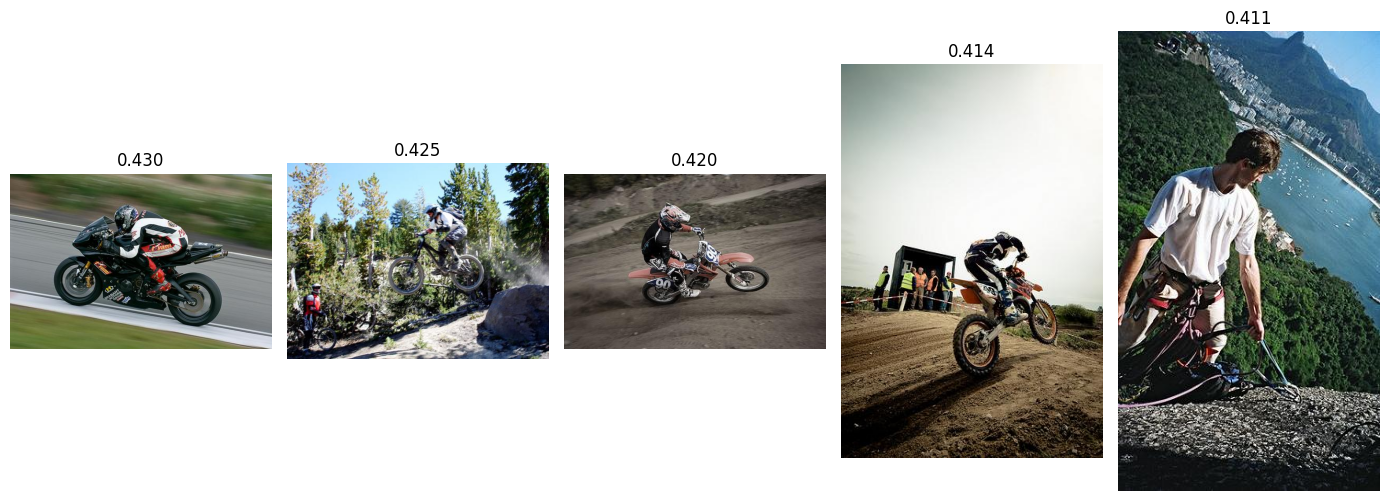

TypeError: query_image doit être str, PIL.Image ou Tensor

In [ ]:
# 1) construire l’index
index_val = build_clip_index_hf(clip_model, val_loader, device=device)

# 2) texte -> images
show_retrieval_from_text_hf(
    clip_model, index_val,
    query_text="a man riding a bike",
    tokenizer=hf_tokenizer,
    max_len=128,
    topk=5,
    device=device
)



Top captions:
#1 score=0.4020 | A man in a blue shirt is spraying a sand sculpture .
#2 score=0.3445 | A brown and white dog is standing in the river by the bank .
#3 score=0.3419 | A black dog carrying a colorful ball swims .
#4 score=0.3410 | three black dogs are swimming through some murky brown water , one with a yellow object in its mouth .
#5 score=0.3408 | A boy and a girl are standing on a river bank facing the water .


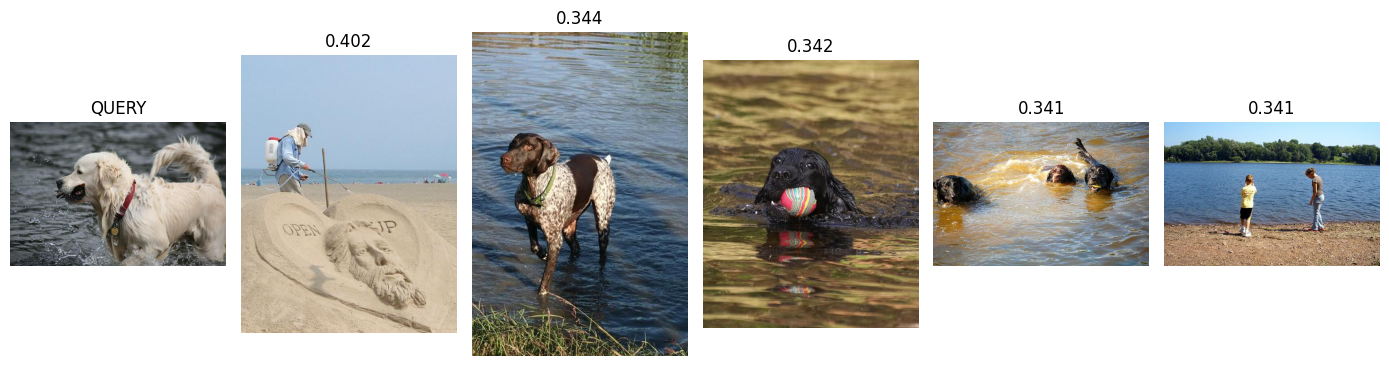

[(0.402023047208786,
  'A man in a blue shirt is spraying a sand sculpture .',
  '../data/final_dataset_noaug2/base_water/water_082/base_water_082.jpg'),
 (0.3444952368736267,
  'A brown and white dog is standing in the river by the bank .',
  '../data/final_dataset_noaug2/base_dog/dog_130/base_dog_130.jpg'),
 (0.34187692403793335,
  'A black dog carrying a colorful ball swims .',
  '../data/final_dataset_noaug2/base_water/water_136/base_water_136.jpg'),
 (0.3409590721130371,
  'three black dogs are swimming through some murky brown water , one with a yellow object in its mouth .',
  '../data/final_dataset_noaug2/base_water/water_148/base_water_148.jpg'),
 (0.34080055356025696,
  'A boy and a girl are standing on a river bank facing the water .',
  '../data/final_dataset_noaug2/base_water/water_042/base_water_042.jpg')]

In [127]:
# 3) image -> captions
show_retrieval_from_image_hf(
    clip_model, index_val,
    query_image=Image.open(val_ds._get_img_path_from_idx(121)),
    transform=transform,
    topk=5,
    device=device
)


In [135]:
t2i, i2t = evaluate_clip_recall(index_val, ks=(1,5,10), device="cpu")
print("Text -> Image:", t2i)
print("Image -> Text:", i2t)


Text -> Image: {'R@1': 0.03809523954987526, 'R@5': 0.14761905372142792, 'R@10': 0.2380952388048172}
Image -> Text: {'R@1': 0.01904761977493763, 'R@5': 0.13809524476528168, 'R@10': 0.24285714328289032}


In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def tsne_plot_embeddings(index, which="image", max_points=1000, perplexity=30, random_state=42):
    """
    which: "image" ou "text"
    max_points: limite pour accélérer (t-SNE est lent)
    """
    assert which in ("image", "text")

    X = index["img_embs"] if which == "image" else index["txt_embs"]
    X = X.numpy()

    y = index.get("labels", None)
    if y is not None:
        y = np.array(y)

    # sous-échantillonnage si besoin
    n = X.shape[0]
    if n > max_points:
        sel = np.random.RandomState(random_state).choice(n, size=max_points, replace=False)
        X = X[sel]
        if y is not None:
            y = y[sel]

    tsne = TSNE(
        n_components=2,
        perplexity=min(perplexity, max(5, (X.shape[0] - 1) // 3)),
        init="pca",
        learning_rate="auto",
        random_state=random_state
    )
    Z = tsne.fit_transform(X)

    plt.figure(figsize=(8, 6))
    if y is None:
        plt.scatter(Z[:,0], Z[:,1], s=10)
    else:
        for lab in np.unique(y):
            m = (y == lab)
            plt.scatter(Z[m,0], Z[m,1], s=10, label=str(lab))
        plt.legend(title="label", loc="best")
    plt.title(f"t-SNE ({which} embeddings)")
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.tight_layout()
    plt.show()


In [ ]:
def tsne_plot_joint(index, max_points=1000, perplexity=30, random_state=42):
    img = index["img_embs"].numpy()
    txt = index["txt_embs"].numpy()

    n = img.shape[0]
    if n > max_points:
        sel = np.random.RandomState(random_state).choice(n, size=max_points, replace=False)
        img = img[sel]
        txt = txt[sel]

    X = np.vstack([img, txt])
    kind = np.array(["img"] * img.shape[0] + ["txt"] * txt.shape[0])

    tsne = TSNE(
        n_components=2,
        perplexity=min(perplexity, max(5, (X.shape[0] - 1) // 3)),
        init="pca",
        learning_rate="auto",
        random_state=random_state
    )
    Z = tsne.fit_transform(X)

    plt.figure(figsize=(8, 6))
    for k in ["img", "txt"]:
        m = (kind == k)
        plt.scatter(Z[m,0], Z[m,1], s=10, label=k)
    plt.legend(loc="best")
    plt.title("t-SNE joint (image vs text embeddings)")
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.tight_layout()
    plt.show()


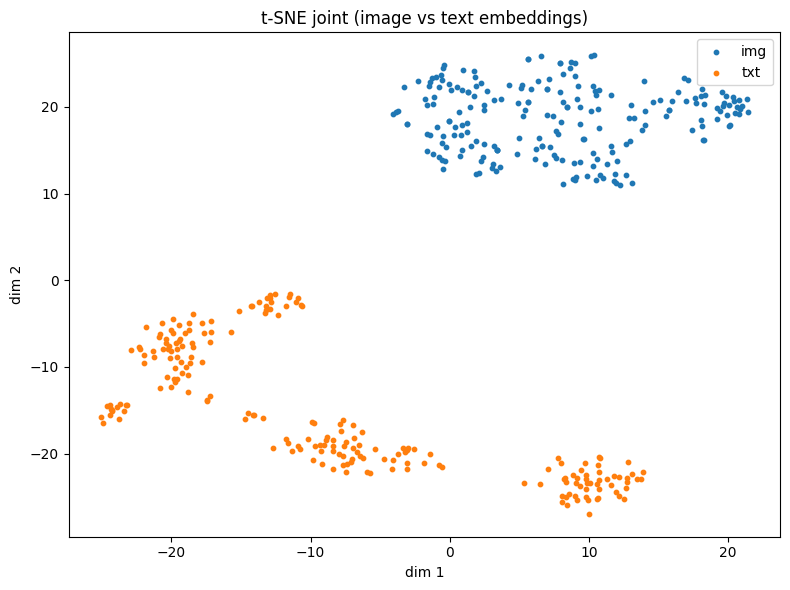

In [139]:
tsne_plot_joint(index_val, max_points=800)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
train_ds = CLIPDataset(df_train, base_dir=base_dir, transform=transform_resnet,
                       hf_tokenizer=hf_tokenizer, max_seq_len=128,
                       text_mode="hf")

val_ds = CLIPDataset(df_val, base_dir=base_dir, transform=transform_resnet,
                     hf_tokenizer=hf_tokenizer, max_seq_len=128,
                     text_mode="hf")

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,
                          num_workers=4, pin_memory=True,
                          collate_fn=clip_collate)

val_loader = DataLoader(val_ds, batch_size=64, shuffle=False,
                        num_workers=4, pin_memory=True,
                        collate_fn=clip_collate)

# 1) Charger resnet fine-tuné
resnet_cls = load_best_resnet18(
    num_classes=4,
    ckpt_path="best-model-resnet.pth",
    device=device
).to(device)

# 2) Créer image encoder CLIP à partir du resnet
img_encoder = ImageEncoderFromResNet18(resnet_cls, proj_dim=256, train_backbone=True)

# 3) distilbert_cls = ton modèle HF chargé (best_distilbert.pth)
txt_encoder = TextEncoderFromDistilBERT(distilbert_cls, proj_dim=256)

# 4) Modèle CLIP complet
clip_model = CLIPLikeModelHF(img_encoder, txt_encoder, init_temp=0.07).to(device)
def set_trainable(m, flag: bool):
    for p in m.parameters():
        p.requires_grad = flag

# Warmup: entraîner seulement les projections + logit_scale
set_trainable(clip_model.image_encoder.backbone, False)
set_trainable(clip_model.text_encoder.backbone, False)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, clip_model.parameters()),
    lr=1e-3, weight_decay=1e-4
)

fit_hf(clip_model, train_loader, val_loader, optimizer, epochs=3, device=device)

# Fine-tune complet avec LR plus petit
set_trainable(clip_model.image_encoder.backbone, True)
set_trainable(clip_model.text_encoder.backbone, True)

optimizer = torch.optim.AdamW(clip_model.parameters(), lr=1e-5, weight_decay=1e-4)
fit_hf(clip_model, train_loader, val_loader, optimizer, epochs=10, device=device)
